# First task
- Build a dataset of spin glass graphs with a fixed number of nodes (10) andd study the learning of energy by a GNN with a different number of connections.

### Table of contents:
1. [Utility functions](#functions)
2. [Definition of the GNN model](#gnn_definition)
3. [Training and validation](#training)
4. [Magnetization Learning (for task 2)](#magnetization)


In [1]:
# import the libraries
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import torch.nn.functional as F
from torch_geometric.profile import get_model_size

from torch.nn import Linear
from torch_geometric.nn import global_max_pool, GraphConv
from torch_geometric.loader import DataLoader

import os 


In [2]:
# set standard dimensions for the plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14


# Utility functions <a class="anchor" id="functions"></a>
In the following cell there are functions used to build the graph and for the first task. 

In [3]:
# The following functions are used to create the dataset for the SpinGlass model


def initialize_graph(L, periodic=True, n_dimensions=2):
    """
    Initialize a graph with L nodes
    """
    G = nx.Graph()
    for i in range(L):
        G.add_node(i, spin = np.random.choice([-1, 1]))
    
    for i in range(L):
        if periodic:
            for j in range(i+1, i+n_dimensions+1):
                G.add_edge(i, j % L, weight = np.random.rand()*2 -1 )
        else:
            for j in range(i+1, i+n_dimensions+1):
                if j < L:
                    G.add_edge(i, j, weight = np.random.rand()*2 -1 )
    return G
     

def plot_graph(G, pos=None):
    """
    Plot the graph with nodes colored according to their spin.
    """
    if pos is None:
        pos = nx.circular_layout(G)
    colors = ['blue' if G.nodes[i]["spin"] == 1 else 'red' for i in range(len(G.nodes) )]
    fig = plt.figure()
    nx.draw(G, pos = pos, node_color=colors, with_labels=True)
    plt.show(fig)    
    return fig
    

def calculate_energy(G, h=0 ):
    """
    Calculate the energy of the graph
    """
    E = 0
    E_h = 0
    for i, j in G.edges:
        E += G[i][j]["weight"] * G.nodes[i]["spin"] * G.nodes[j]["spin"]

    if h != 0:  # exclude the case of h = 0 to avoid floating point errors
        E_h = h * np.sum([G.nodes[i]["spin"] for i in G.nodes]) 

    return -E/2 - E_h  # divide by 2 to avoid double counting

def calculate_magnetization(G):
    """
    Calculate the magnetization of the graph
    """
    return np.sum([G.nodes[i]["spin"] for i in G.nodes])

# create a dataset with the energy as label
def create_dataset(n_nodes=10, h=0, periodic= True, n_dimensions=1, n_samples=1000, return_MLP=False, save = False, path = None, mode = "energy"):
    dataset = []
    graphs = []
    MLP_list= []

    if mode == "energy":
        bool_energy = True
    elif mode == "magnetization":
        bool_energy = False
    else:
        raise ValueError("mode must be either 'energy' or 'magnetization'")

    for i in range(n_samples):
        G = initialize_graph(n_nodes, periodic=periodic, n_dimensions=n_dimensions)
        X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
        graphs.append(G)

        if bool_energy:
            Y = torch.tensor([calculate_energy(G, h=h)]).float()
        else:
            Y = torch.tensor([calculate_magnetization(G)]).float()

        dataset.append(
            Data(x = X, 
                edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long),
                edge_weight = torch.tensor([G[i][j]["weight"] for i, j in G.edges], dtype=torch.float),
                y = Y ) )  
                

        if save:
            if path is None:
                path = os.getcwd()
            if not os.path.exists(path):
                os.makedirs(path)
            torch.save(dataset, os.path.join(path, f"dataset_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt"))
            torch.save(graphs, os.path.join(path, f"graphs_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt"))

    if return_MLP:

        # extract the adjacency matrix
        A = nx.adjacency_matrix(G).todense()
        # concatenate the adjacency matrix to the node features to use it for the MLP in the other task
        M = torch.cat([X, torch.tensor(A).float()], dim=1)
        MLP_list.append(M)

        if save:
            torch.save(MLP_list, os.path.join(path, f"MLP_list_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt"))
        return dataset, graphs, MLP_list
    else:
        return dataset, graphs

# Definition of the GNN model <a class="anchor" id="gnn_definition"></a>


In [4]:
# GNN model

class GNN(torch.nn.Module):
    """
    class for the GNN model

    inputs parameters:
    - hidden_channels_1: number of hidden channels for the first layer
    - hidden_channels_2: number of hidden channels for the second layer
    - hidden_channels_3: number of hidden channels for the third layer
    - hidden_channels_4: number of hidden channels for the fourth layer
    - hidden_linear: number of hidden channels for the linear layer
    - lr: learning rate
    - weight_decay: weight decay
    - dropout: dropout rate
    - num_node_features: number of node features
    - num_classes: number of classes

    output:
    - out: the output of the model
    """
    def __init__(self,hidden_channels_1=16, hidden_channels_2=16, hidden_channels_3=16,hidden_channels_4 = 16, hidden_linear=16,
                 lr = 1e-5, weight_decay=1e-3, dropout=0.5, num_node_features=1, num_classes=1):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(num_node_features,hidden_channels_1)
        self.conv2 = GraphConv(hidden_channels_1, hidden_channels_2)
        self.conv3 = GraphConv(hidden_channels_2, hidden_channels_3)
        self.conv4 = GraphConv(hidden_channels_3, hidden_channels_4)

        self.pool = global_max_pool

        self.linear1 = Linear(hidden_channels_4, hidden_linear)
        self.linear2 = Linear(hidden_linear, num_classes)

        

        self.dropout = torch.nn.Dropout(dropout)

        # we should consider also batch normalization in case of overfitting



        # Optimizer:
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Loss function:
        self.criterion = torch.nn.MSELoss()

        
    
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv2(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv3(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv4(x, edge_index, edge_weight))

        x = self.pool(x, data.batch) # [n_nodes*n_graph_of_the_batch, n_features] -> [n_graph_of_the_batch, n_features]

        #x = torch.flatten(x) # not needed since we are using global_max_pool
        #print(x.shape)
        x = self.dropout(x)
        x = F.leaky_relu(self.linear1(x))
        out = self.linear2(x)

        return out
    

    
    def train_step(self, data):
        # Reset gradients
        self.optimizer.zero_grad()
        # Passing the node features and the connection info
        prediction = self.forward(data)
        # reshape the prediction to match the shape of the target
        prediction = prediction.view(data.y.shape)
        # Calculating the loss and gradients
        loss = self.criterion(prediction, data.y)
        #print("prediction:",prediction.shape)
        #print("data.y:",data.y.shape)
        loss.backward()
        # Update using the gradients
        self.optimizer.step()
        
        return loss.item()
    

In [5]:
def plot_loss( train_losses, test_losses):
    fig = plt.figure()
    epoch = range(1, len(train_losses)+1)
    plt.plot(epoch, train_losses, label='Training Loss')
    plt.plot(epoch, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig


def train_model(model, train_loader, test_loader, num_epochs, patience = 5, model_name='best_model', verbose = True, device= None, ax_name = "energy"):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # parameters for patience
    best_loss = np.inf
    patience_counter = 0


    epochs = range(1, num_epochs+1)
    train_losses, test_losses = [], []
    
    print('Training ...')

    for epoch in epochs:
        loss_per_epoch = []
        test_loss_per_epoch = []

        for i, mini_batch in enumerate(train_loader):
            mini_batch.to(device)
            train_loss = model.train_step(mini_batch)
            loss_per_epoch.append(train_loss)

        train_losses.append(sum(loss_per_epoch)/len(loss_per_epoch))


        with torch.no_grad():
            """Evaluate the model on test set"""
            for i, mini_batch in enumerate(test_loader):
                mini_batch.to(device)
                prediction = model.forward(mini_batch)
                prediction.to('cpu')
                test_loss = model.criterion(prediction, mini_batch.y).item()
                test_loss_per_epoch.append(test_loss)
            test_losses.append(sum(test_loss_per_epoch)/len(test_loss_per_epoch))
            
            if test_losses[-1] < best_loss:
                best_loss = test_losses[-1]
                torch.save(model.state_dict(), model_name + '/model.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        if verbose:
            print(f"Ep {epoch} \t| Loss {round(train_losses[-1], 5)} \t| Test Loss {round(test_losses[-1], 5)}")


    return  train_losses, test_losses

In [6]:
# set the model name based on the values
def set_model_name(n_nodes, n_dimensions, h, periodic,n_samples, hidden_channels_1,
                    hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear,
                    lr, weight_decay, dropout, epochs):
    return f"model_{n_nodes}_{n_dimensions}_{h}_{periodic}_{n_samples}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{hidden_channels_4}_{hidden_linear}_{lr}_{weight_decay}_{dropout}_{epochs}"


# translate the model name into values
def print_values_from_model_name(model_name, print_values=True, return_dict = False): 
    values = model_name.split('_')
    # create a dictionary to store the values 
    dict = {"n_nodes": values[1], "n_dimensions": values[2], "h": values[3], "periodic": values[4], "n_samples": values[5],
            "hidden_channels_1": values[6], "hidden_channels_2": values[7], "hidden_channels_3": values[8], "hidden_channels_4": values[9], "hidden_linear": values[10],
            "lr": values[11], "weight_decay": values[12], "dropout": values[13], "epochs": values[14]}
    if print_values:
        for key, value in dict.items():
            print(f"{key}: {value}")
    if return_dict:
        return dict
    
    

def test_trained_model(model_name, test_loader, device = None, ax_name = "energy"):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    values = print_values_from_model_name(model_name, print_values=False, return_dict=True)

    trained_model = GNN(hidden_channels_1= int(values["hidden_channels_1"]),
                hidden_channels_2= int(values["hidden_channels_2"]),
                hidden_channels_3= int(values["hidden_channels_3"]),
                hidden_channels_4= int(values["hidden_channels_4"]),
                hidden_linear= int(values["hidden_linear"]),
                lr= float(values["lr"]), weight_decay= float(values["weight_decay"]), dropout= float(values["dropout"]))
    
    trained_model.load_state_dict(torch.load(model_name + '/model.pth'))
    trained_model.to(device)

    fig = plt.figure()
    with torch.no_grad():
        predictions = []
        true_values = []
        for i, mini_batch in enumerate(test_loader):
            mini_batch.to(device)
            prediction = trained_model.forward(mini_batch)
            predictions.append(prediction.item())
            true_values.append(mini_batch.y.item())
        
        # save the mean squared error
        mse = np.mean((np.array(predictions) - np.array(true_values))**2)
       
        plt.scatter(true_values, predictions)
        plt.plot(true_values, true_values, color='red')
        plt.xlabel('True ' + ax_name)
        plt.ylabel('Predicted' + ax_name)
        plt.title('Predicted vs True ' + ax_name)
    
        at = AnchoredText(f"MSE: {np.round(mse,2)}", frameon=True, loc='upper left')
        plt.gca().add_artist(at)

        # plot a box similar to the legend to show the MSE
        plt.grid(True)
        plt.show()
    
    

    return fig, mse


In [7]:
# set the device and a random seed
torch.manual_seed(1022000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: ', device)

# set the palette
palette = sns.color_palette("coolwarm", as_cmap=True)

Device:  cuda


# Training and validation <a class="anchor" id="training"></a>

In [19]:
# set standard parameters for the model

# parameters for the dataset
n_nodes = 10
h = 0
n_samples = 1000

# parameters for the model
num_epochs = 30
batch_size = 1
lr = 5e-4
weight_decay = 1e-4
dropout = 0.4
patience = 15

# parameters for the layers
hidden_channels_1 = 16
hidden_channels_2 = 32
hidden_channels_3 = 32
hidden_channels_4 = 64
hidden_linear = 32

In [20]:
# create the model
starting_model = GNN(hidden_channels_1=hidden_channels_1, hidden_channels_2=hidden_channels_2, hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4, hidden_linear=hidden_linear, lr=lr, weight_decay=weight_decay, dropout=dropout)

# Model size and number of parameters of the model:
print(44 * '-')
print("Model:")
print("Model size (bytes):\t\t  ", get_model_size(starting_model))
print("Number of parameters:\t\t  ", sum(p.numel() for p in starting_model.parameters()))
print(44 * '-')


--------------------------------------------
Model:
Model size (bytes):		   43862
Number of parameters:		   9457
--------------------------------------------


In [21]:
# prepare lists to store the results
list_dimensions = [1,2,3,4,5]
list_periodic = [False, True]
list_datasets = []
list_graphs = []
list_n_connections = []
list_model_names = []
list_train_losses = []
list_test_losses = []
list_fig_losses = []
list_fig_tests = []
list_mse = []

In [22]:
# create and save the datasets
create = True
save = True


# MLP_list is really time consuming,
# it's more clever to save only the datasets and build the graphs and MLP_list again if needed (task 2)


try:
    os.mkdir("datasets")
except:
    pass

if create:
    for n_dimensions in list_dimensions:
        for periodic in list_periodic:
            print(f"creating datasets with: n_dimensions: {n_dimensions}, periodic: {periodic}")
            
            dataset, graphs = create_dataset(n_nodes=n_nodes, h=h, periodic=periodic, n_dimensions=n_dimensions, n_samples=n_samples, save=False)
            list_datasets.append(dataset)
            list_graphs.append(graphs)

            if save:
                torch.save(dataset, f"datasets/dataset_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
                torch.save(graphs, f"datasets/graphs_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
else:
    print("loading datasets")
    for n_dimensions in list_dimensions:
        for periodic in list_periodic:
            dataset = torch.load(f"datasets/dataset_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
            graphs = torch.load(f"datasets/graphs_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
            list_datasets.append(dataset)
            list_graphs.append(graphs)
print("Done!")

creating datasets with: n_dimensions: 1, periodic: False
creating datasets with: n_dimensions: 1, periodic: True
creating datasets with: n_dimensions: 2, periodic: False
creating datasets with: n_dimensions: 2, periodic: True
creating datasets with: n_dimensions: 3, periodic: False
creating datasets with: n_dimensions: 3, periodic: True
creating datasets with: n_dimensions: 4, periodic: False
creating datasets with: n_dimensions: 4, periodic: True
creating datasets with: n_dimensions: 5, periodic: False
creating datasets with: n_dimensions: 5, periodic: True
Done!


n_dimensions: 1, periodic: False, number of connections: 9


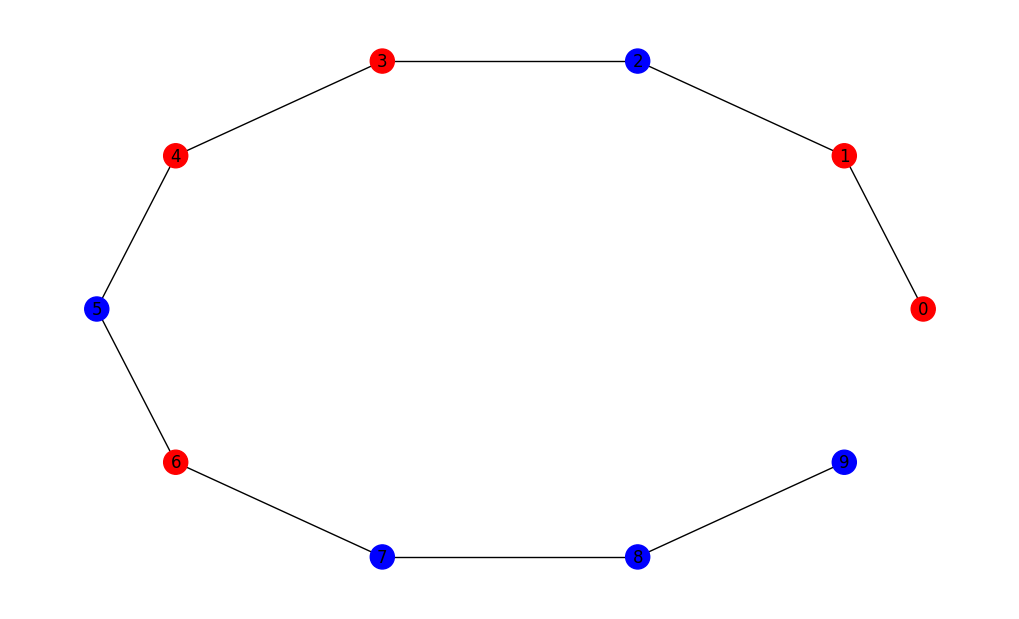

Training ...


/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Ep 1 	| Loss 0.67615 	| Test Loss 0.36329
Ep 2 	| Loss 0.27453 	| Test Loss 0.25509
Ep 3 	| Loss 0.22301 	| Test Loss 0.24349
Ep 4 	| Loss 0.18782 	| Test Loss 0.17563
Ep 5 	| Loss 0.18463 	| Test Loss 0.20603
Ep 6 	| Loss 0.16475 	| Test Loss 0.18231
Ep 7 	| Loss 0.15625 	| Test Loss 0.14393
Ep 8 	| Loss 0.15092 	| Test Loss 0.15691
Ep 9 	| Loss 0.14749 	| Test Loss 0.15865
Ep 10 	| Loss 0.13408 	| Test Loss 0.22364
Ep 11 	| Loss 0.13251 	| Test Loss 0.16893
Ep 12 	| Loss 0.13399 	| Test Loss 0.1459
Ep 13 	| Loss 0.12649 	| Test Loss 0.13969
Ep 14 	| Loss 0.12829 	| Test Loss 0.15352
Ep 15 	| Loss 0.11946 	| Test Loss 0.13625
Ep 16 	| Loss 0.10932 	| Test Loss 0.14503
Ep 17 	| Loss 0.12082 	| Test Loss 0.13039
Ep 18 	| Loss 0.11719 	| Test Loss 0.13562
Ep 19 	| Loss 0.11032 	| Test Loss 0.12501
Ep 20 	| Loss 0.10255 	| Test Loss 0.15339
Ep 21 	| Loss 0.10377 	| Test Loss 0.1324
Ep 22 	| Loss 0.10461 	| Test Loss 0.12084
Ep 23 	| Loss 0.09353 	| Test Loss 0.1294
Ep 24 	| Loss 0.08873 	

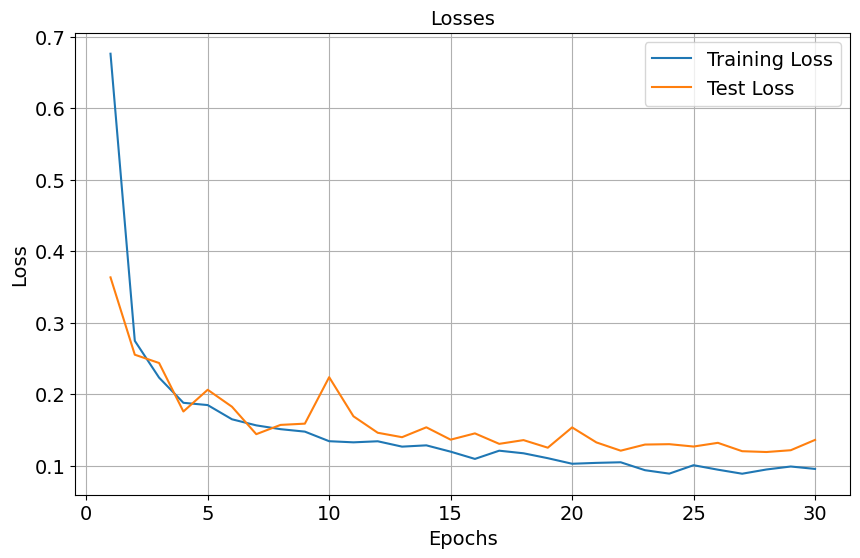

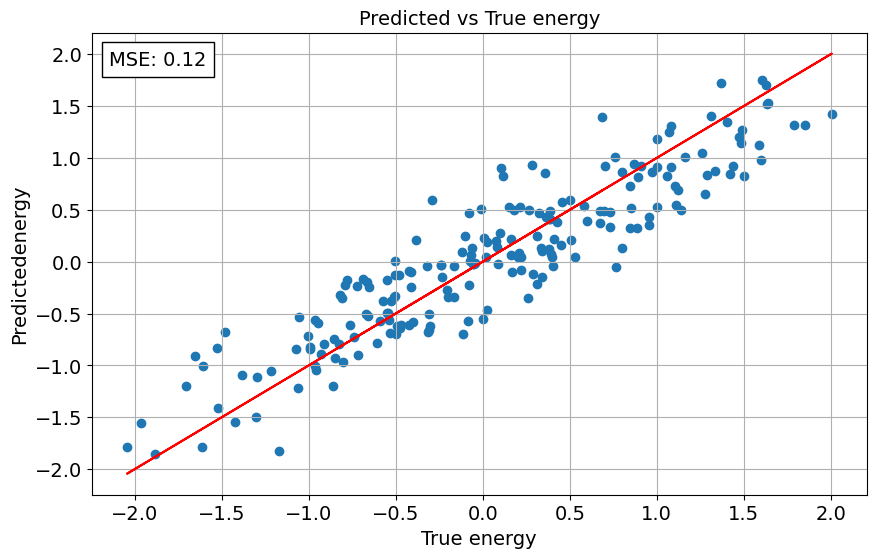

--------------------------------------------


n_dimensions: 1, periodic: True, number of connections: 10


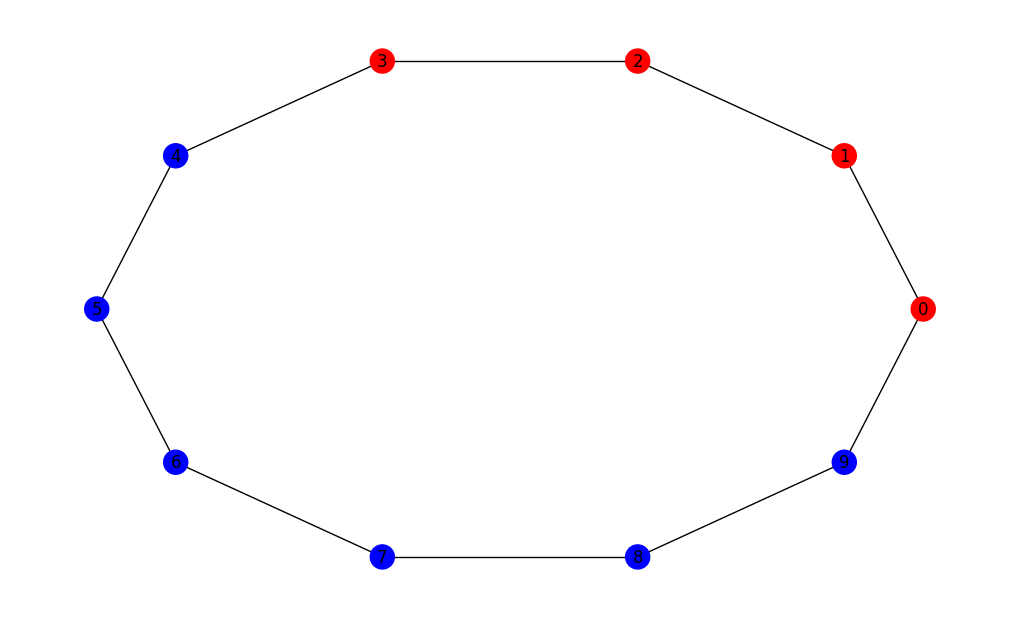

Training ...
Ep 1 	| Loss 0.73902 	| Test Loss 0.3969
Ep 2 	| Loss 0.38799 	| Test Loss 0.25202
Ep 3 	| Loss 0.25462 	| Test Loss 0.25732
Ep 4 	| Loss 0.23193 	| Test Loss 0.21713
Ep 5 	| Loss 0.22138 	| Test Loss 0.20773
Ep 6 	| Loss 0.20095 	| Test Loss 0.25202
Ep 7 	| Loss 0.19297 	| Test Loss 0.22776
Ep 8 	| Loss 0.19412 	| Test Loss 0.1844
Ep 9 	| Loss 0.18771 	| Test Loss 0.18116
Ep 10 	| Loss 0.17746 	| Test Loss 0.17204
Ep 11 	| Loss 0.15862 	| Test Loss 0.15611
Ep 12 	| Loss 0.1846 	| Test Loss 0.18353
Ep 13 	| Loss 0.14646 	| Test Loss 0.16222
Ep 14 	| Loss 0.16867 	| Test Loss 0.16334
Ep 15 	| Loss 0.15012 	| Test Loss 0.17478
Ep 16 	| Loss 0.15051 	| Test Loss 0.16072
Ep 17 	| Loss 0.14616 	| Test Loss 0.16114
Ep 18 	| Loss 0.14255 	| Test Loss 0.17449
Ep 19 	| Loss 0.13684 	| Test Loss 0.16076
Ep 20 	| Loss 0.13722 	| Test Loss 0.15437
Ep 21 	| Loss 0.13301 	| Test Loss 0.14921
Ep 22 	| Loss 0.12878 	| Test Loss 0.13771
Ep 23 	| Loss 0.13024 	| Test Loss 0.14127
Ep 24 	| L

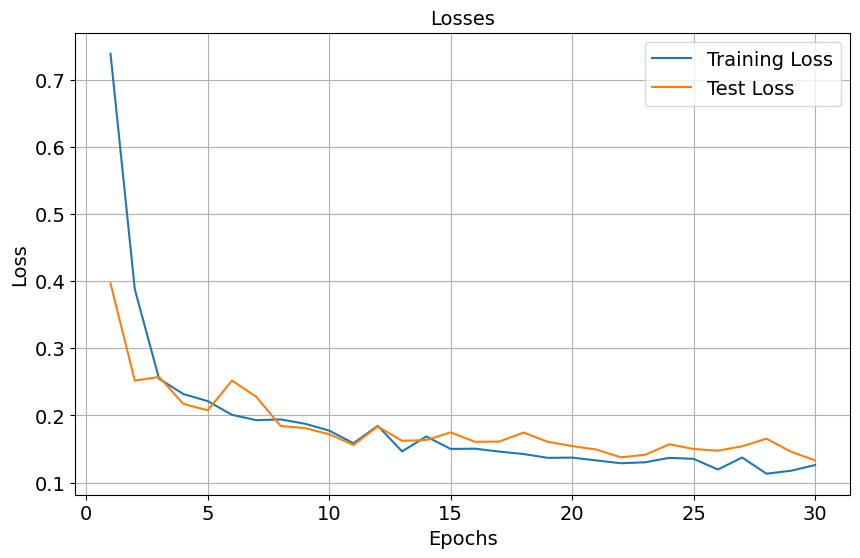

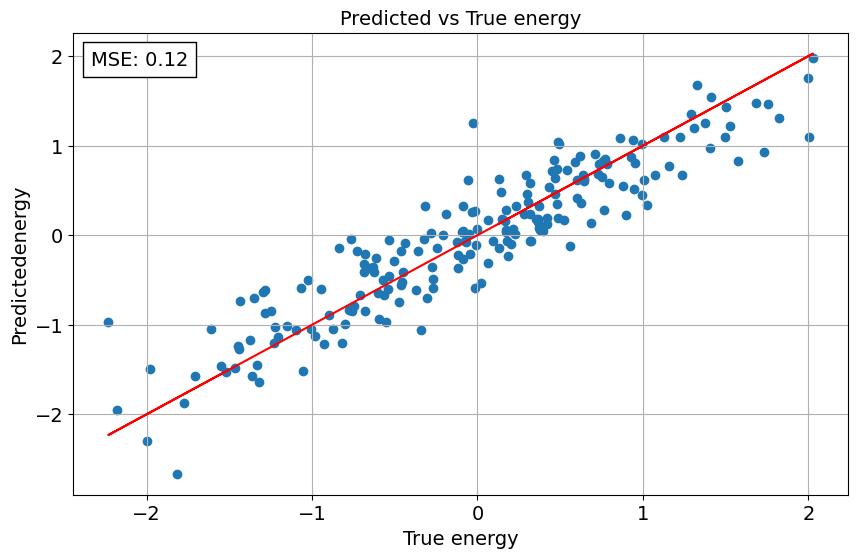

--------------------------------------------


n_dimensions: 2, periodic: False, number of connections: 17


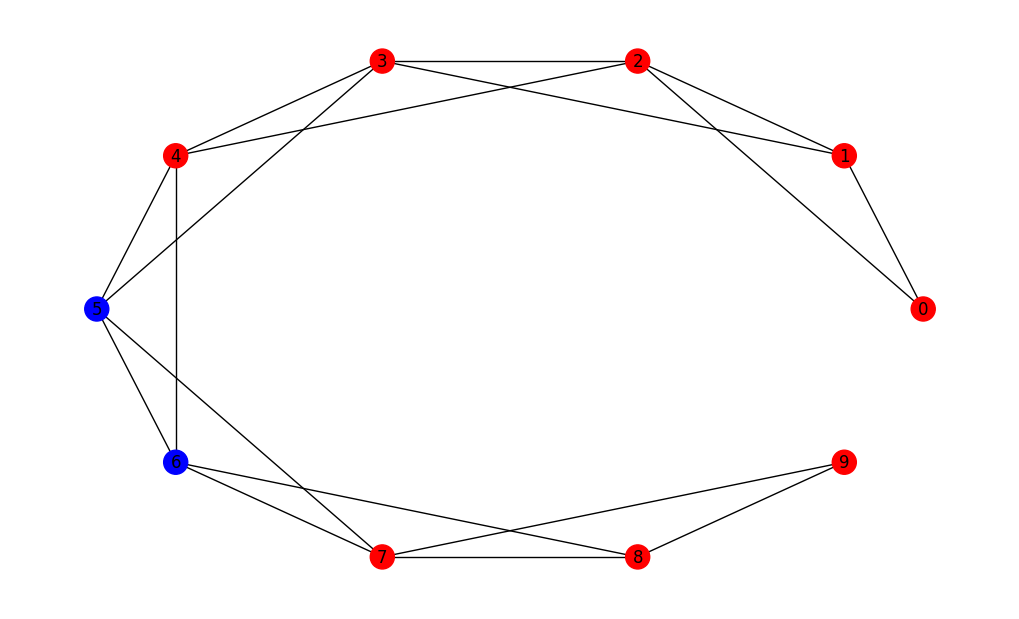

Training ...
Ep 1 	| Loss 1.25168 	| Test Loss 0.84962
Ep 2 	| Loss 0.55708 	| Test Loss 0.59826
Ep 3 	| Loss 0.40085 	| Test Loss 0.42989
Ep 4 	| Loss 0.3656 	| Test Loss 0.49102
Ep 5 	| Loss 0.3318 	| Test Loss 0.40315
Ep 6 	| Loss 0.31334 	| Test Loss 0.31632
Ep 7 	| Loss 0.28768 	| Test Loss 0.33457
Ep 8 	| Loss 0.31422 	| Test Loss 0.28644
Ep 9 	| Loss 0.24801 	| Test Loss 0.2849
Ep 10 	| Loss 0.2838 	| Test Loss 0.35931
Ep 11 	| Loss 0.266 	| Test Loss 0.44506
Ep 12 	| Loss 0.28156 	| Test Loss 0.33587
Ep 13 	| Loss 0.23002 	| Test Loss 0.34891
Ep 14 	| Loss 0.23177 	| Test Loss 0.35264
Ep 15 	| Loss 0.23371 	| Test Loss 0.34189
Ep 16 	| Loss 0.23226 	| Test Loss 0.36091
Ep 17 	| Loss 0.22861 	| Test Loss 0.28383
Ep 18 	| Loss 0.2261 	| Test Loss 0.33717
Ep 19 	| Loss 0.21289 	| Test Loss 0.31213
Ep 20 	| Loss 0.20313 	| Test Loss 0.28264
Ep 21 	| Loss 0.20682 	| Test Loss 0.3325
Ep 22 	| Loss 0.19662 	| Test Loss 0.34634
Ep 23 	| Loss 0.2086 	| Test Loss 0.32753
Ep 24 	| Loss 0.

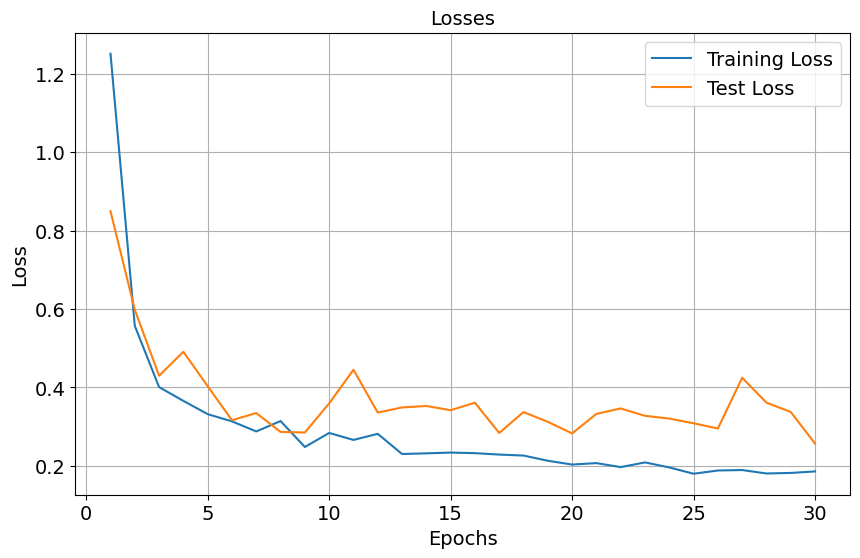

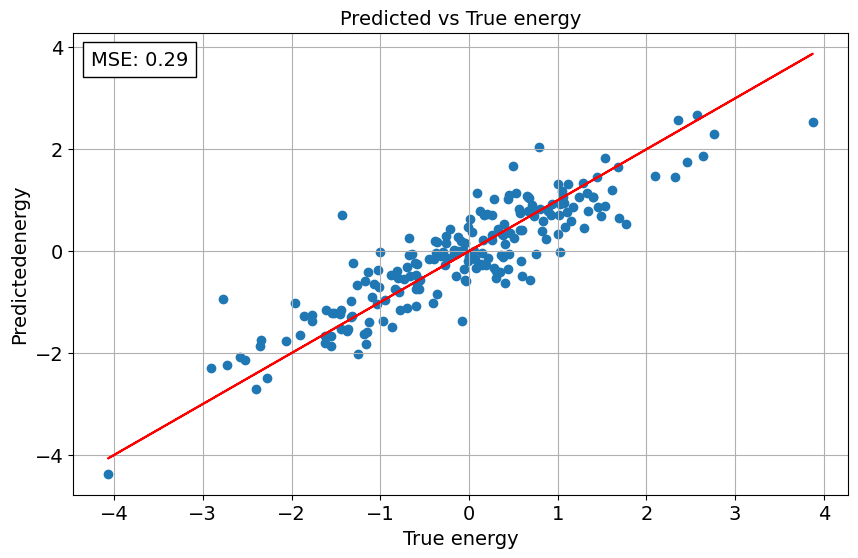

--------------------------------------------


n_dimensions: 2, periodic: True, number of connections: 20


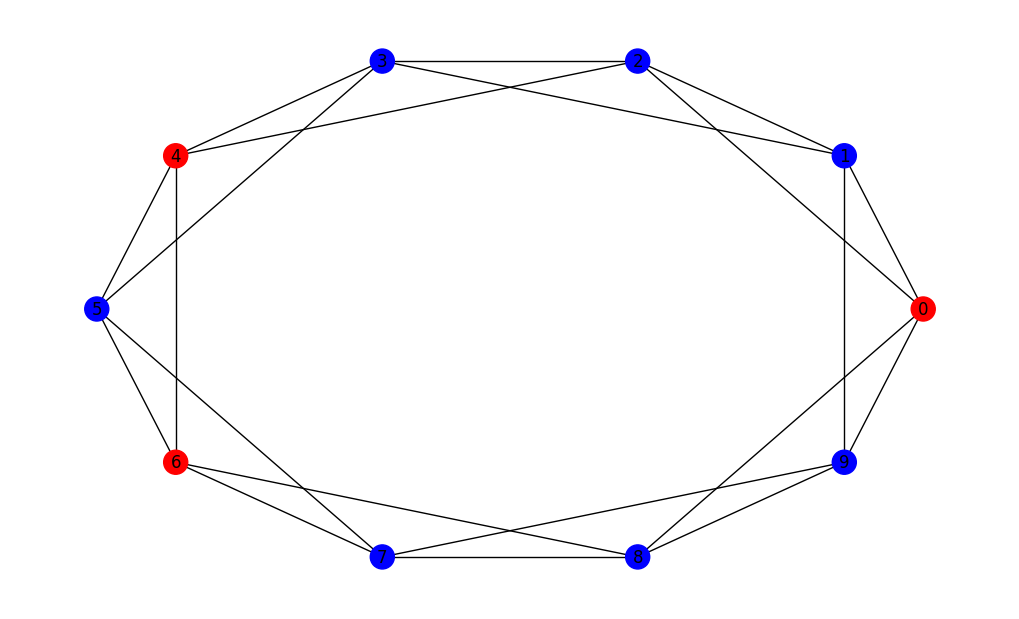

Training ...
Ep 1 	| Loss 1.51566 	| Test Loss 1.39343
Ep 2 	| Loss 0.75605 	| Test Loss 0.74387
Ep 3 	| Loss 0.52203 	| Test Loss 0.60795
Ep 4 	| Loss 0.47921 	| Test Loss 0.40639
Ep 5 	| Loss 0.4296 	| Test Loss 0.38748
Ep 6 	| Loss 0.39777 	| Test Loss 0.44084
Ep 7 	| Loss 0.41635 	| Test Loss 0.48615
Ep 8 	| Loss 0.35434 	| Test Loss 0.3843
Ep 9 	| Loss 0.33809 	| Test Loss 0.3731
Ep 10 	| Loss 0.35563 	| Test Loss 0.37565
Ep 11 	| Loss 0.35013 	| Test Loss 0.33552
Ep 12 	| Loss 0.3089 	| Test Loss 0.33867
Ep 13 	| Loss 0.31065 	| Test Loss 0.34359
Ep 14 	| Loss 0.30391 	| Test Loss 0.46333
Ep 15 	| Loss 0.28873 	| Test Loss 0.42926
Ep 16 	| Loss 0.29545 	| Test Loss 0.2961
Ep 17 	| Loss 0.2726 	| Test Loss 0.29803
Ep 18 	| Loss 0.2619 	| Test Loss 0.2905
Ep 19 	| Loss 0.25504 	| Test Loss 0.36756
Ep 20 	| Loss 0.24977 	| Test Loss 0.30907
Ep 21 	| Loss 0.27077 	| Test Loss 0.29891
Ep 22 	| Loss 0.25654 	| Test Loss 0.26688
Ep 23 	| Loss 0.22784 	| Test Loss 0.30335
Ep 24 	| Loss 0

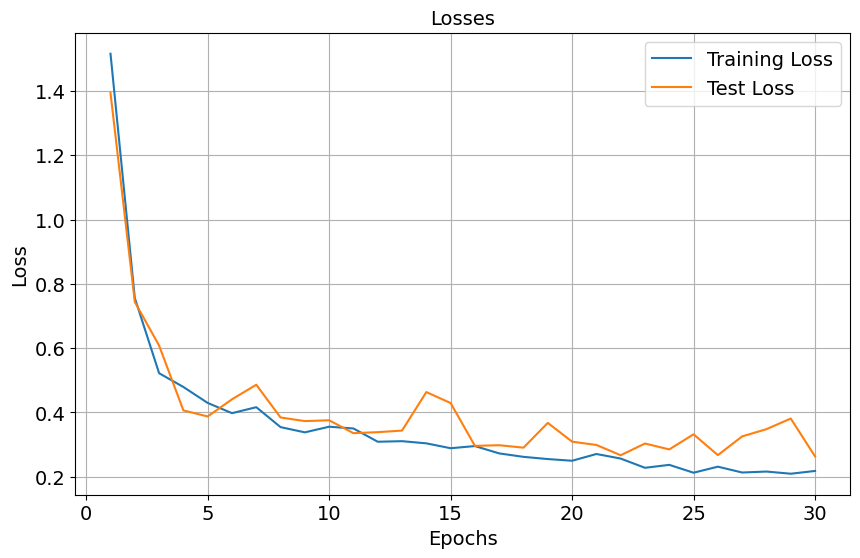

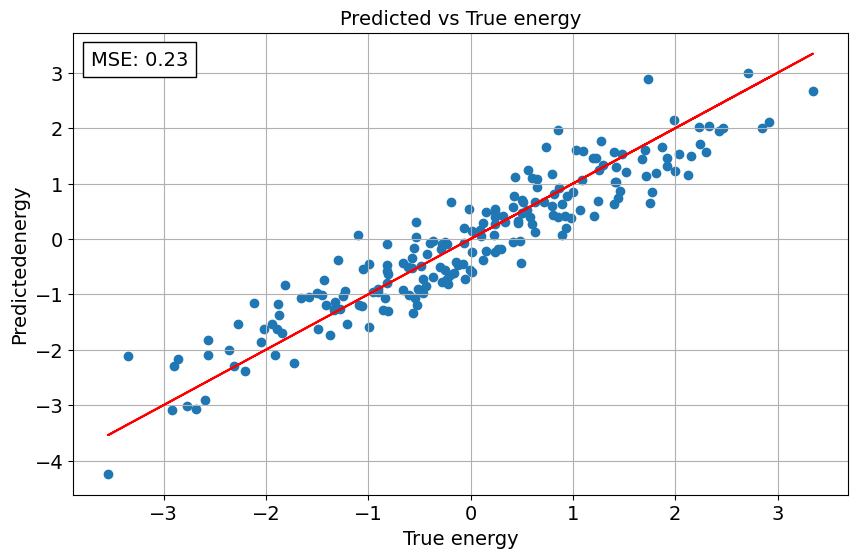

--------------------------------------------


n_dimensions: 3, periodic: False, number of connections: 24


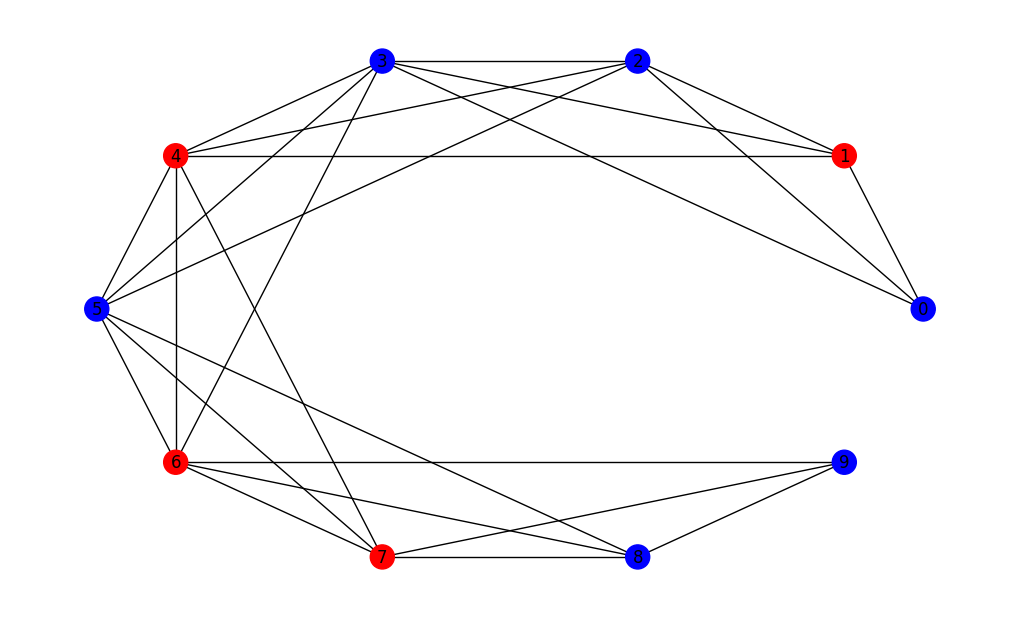

Training ...
Ep 1 	| Loss 1.72979 	| Test Loss 1.44301
Ep 2 	| Loss 0.79189 	| Test Loss 0.73688
Ep 3 	| Loss 0.51829 	| Test Loss 0.61851
Ep 4 	| Loss 0.56157 	| Test Loss 0.67444
Ep 5 	| Loss 0.47925 	| Test Loss 0.63505
Ep 6 	| Loss 0.42533 	| Test Loss 0.62578
Ep 7 	| Loss 0.41975 	| Test Loss 0.49613
Ep 8 	| Loss 0.40278 	| Test Loss 0.5317
Ep 9 	| Loss 0.38552 	| Test Loss 0.49946
Ep 10 	| Loss 0.36811 	| Test Loss 0.46162
Ep 11 	| Loss 0.33179 	| Test Loss 0.4738
Ep 12 	| Loss 0.31822 	| Test Loss 0.45202
Ep 13 	| Loss 0.33225 	| Test Loss 0.61405
Ep 14 	| Loss 0.33492 	| Test Loss 0.48888
Ep 15 	| Loss 0.31244 	| Test Loss 0.56725
Ep 16 	| Loss 0.31695 	| Test Loss 0.47946
Ep 17 	| Loss 0.29267 	| Test Loss 0.45658
Ep 18 	| Loss 0.28037 	| Test Loss 0.46761
Ep 19 	| Loss 0.28895 	| Test Loss 0.40676
Ep 20 	| Loss 0.25071 	| Test Loss 0.47758
Ep 21 	| Loss 0.27004 	| Test Loss 0.44053
Ep 22 	| Loss 0.27235 	| Test Loss 0.44205
Ep 23 	| Loss 0.23956 	| Test Loss 0.50295
Ep 24 	| 

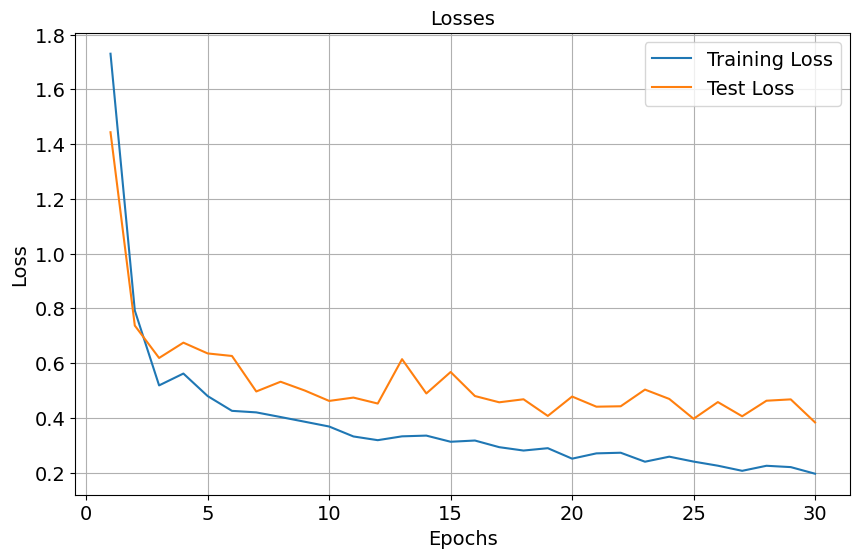

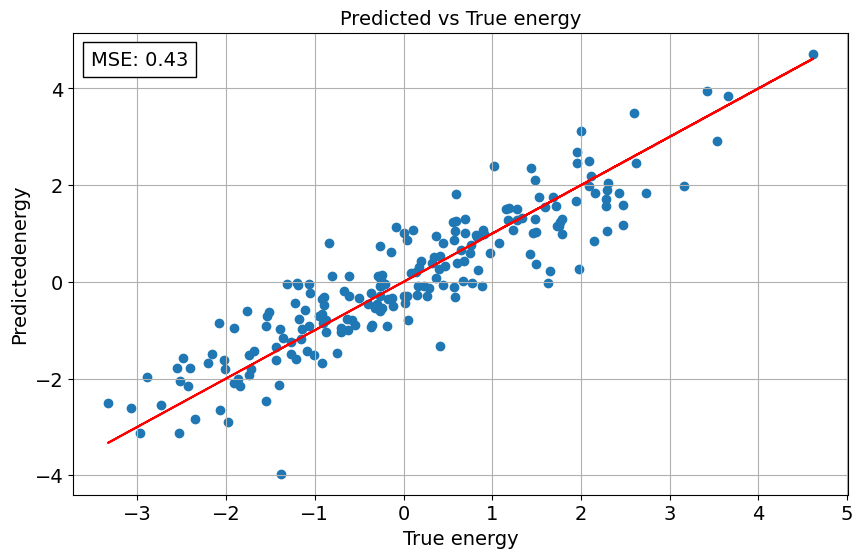

--------------------------------------------


n_dimensions: 3, periodic: True, number of connections: 30


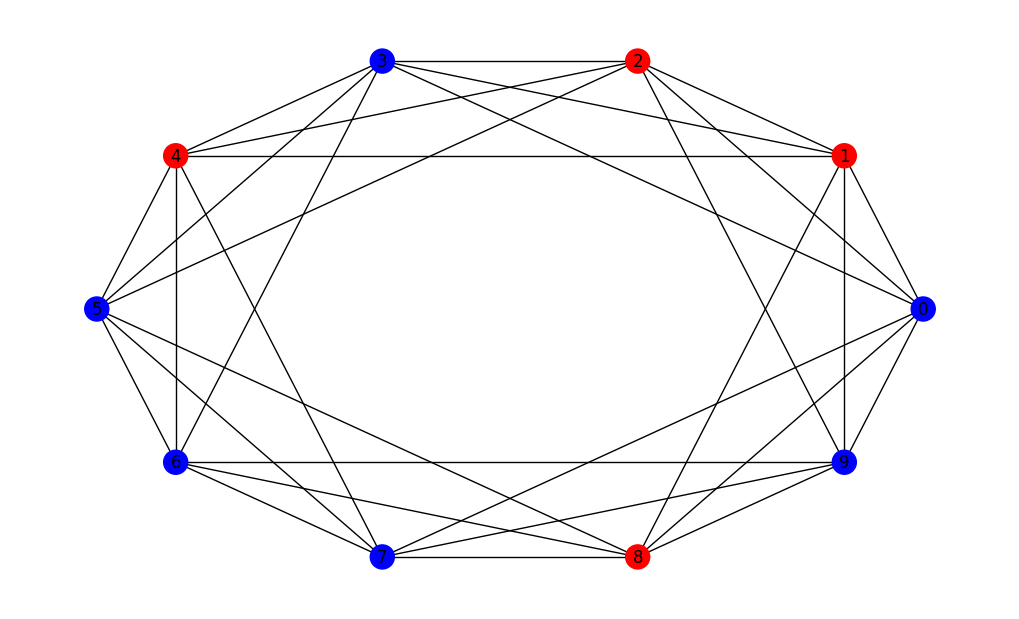

Training ...
Ep 1 	| Loss 2.36052 	| Test Loss 1.3979
Ep 2 	| Loss 1.14334 	| Test Loss 0.86585
Ep 3 	| Loss 0.77537 	| Test Loss 0.66012
Ep 4 	| Loss 0.63666 	| Test Loss 0.64427
Ep 5 	| Loss 0.56419 	| Test Loss 0.55095
Ep 6 	| Loss 0.58352 	| Test Loss 0.55148
Ep 7 	| Loss 0.51996 	| Test Loss 0.53416
Ep 8 	| Loss 0.49184 	| Test Loss 0.50868
Ep 9 	| Loss 0.47935 	| Test Loss 0.65356
Ep 10 	| Loss 0.47091 	| Test Loss 0.60846
Ep 11 	| Loss 0.44753 	| Test Loss 0.5135
Ep 12 	| Loss 0.42709 	| Test Loss 0.54273
Ep 13 	| Loss 0.39752 	| Test Loss 0.52028
Ep 14 	| Loss 0.36153 	| Test Loss 0.44811
Ep 15 	| Loss 0.42462 	| Test Loss 0.48944
Ep 16 	| Loss 0.40343 	| Test Loss 0.41926
Ep 17 	| Loss 0.38322 	| Test Loss 0.52261
Ep 18 	| Loss 0.38627 	| Test Loss 0.50263
Ep 19 	| Loss 0.35759 	| Test Loss 0.50579
Ep 20 	| Loss 0.32825 	| Test Loss 0.46855
Ep 21 	| Loss 0.35742 	| Test Loss 0.46452
Ep 22 	| Loss 0.34219 	| Test Loss 0.59864
Ep 23 	| Loss 0.34567 	| Test Loss 0.58082
Ep 24 	| 

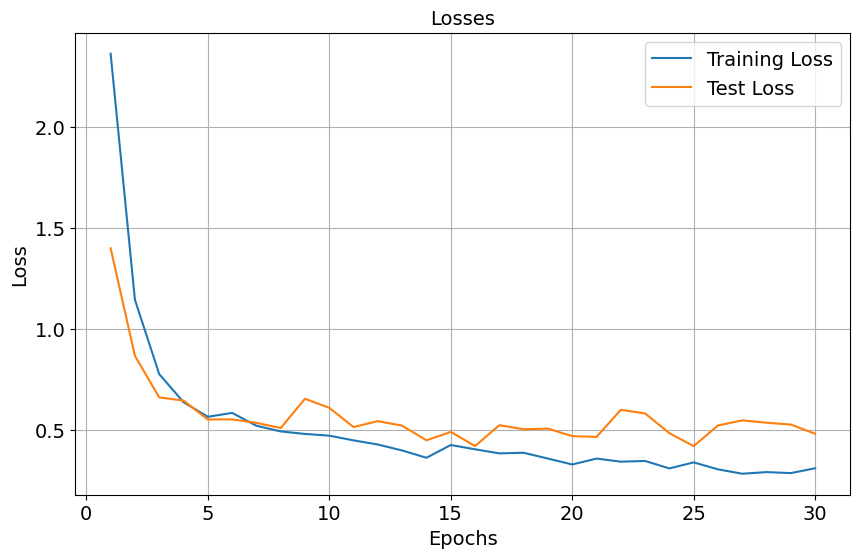

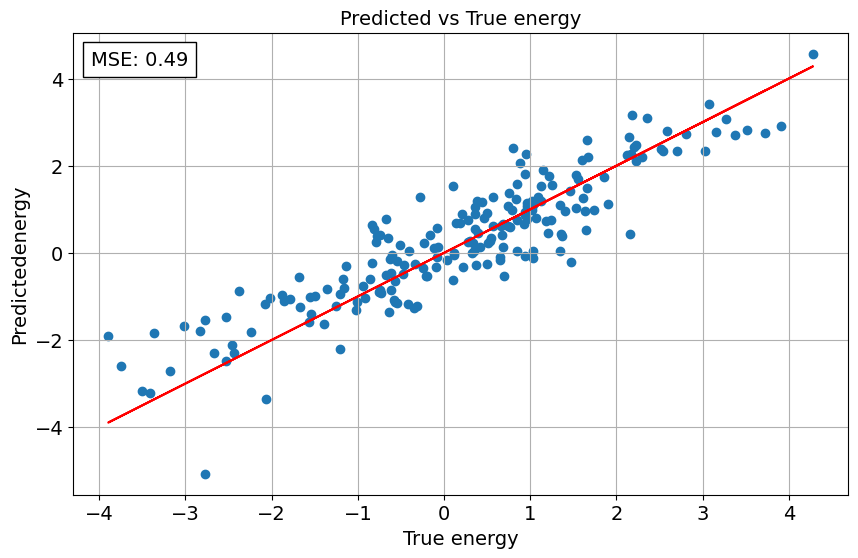

--------------------------------------------


n_dimensions: 4, periodic: False, number of connections: 30


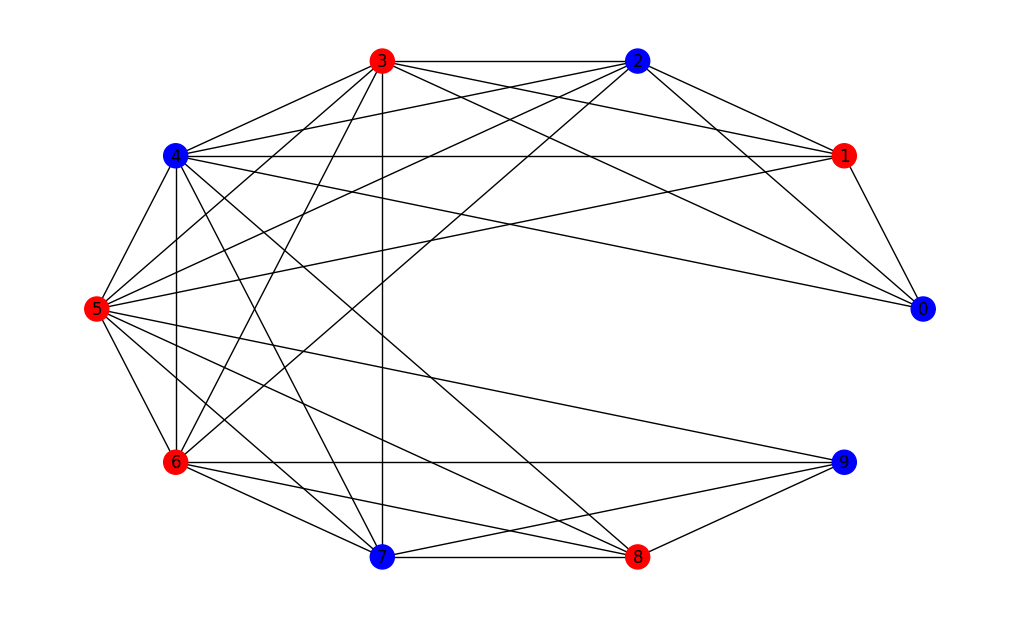

Training ...
Ep 1 	| Loss 2.04986 	| Test Loss 1.47366
Ep 2 	| Loss 1.0187 	| Test Loss 0.71023
Ep 3 	| Loss 0.69066 	| Test Loss 0.78573
Ep 4 	| Loss 0.61105 	| Test Loss 0.55681
Ep 5 	| Loss 0.60158 	| Test Loss 0.59302
Ep 6 	| Loss 0.54169 	| Test Loss 0.56206
Ep 7 	| Loss 0.50134 	| Test Loss 0.4947
Ep 8 	| Loss 0.46941 	| Test Loss 0.56235
Ep 9 	| Loss 0.46702 	| Test Loss 0.51761
Ep 10 	| Loss 0.4339 	| Test Loss 0.5209
Ep 11 	| Loss 0.425 	| Test Loss 0.46913
Ep 12 	| Loss 0.38782 	| Test Loss 0.54666
Ep 13 	| Loss 0.39312 	| Test Loss 0.57215
Ep 14 	| Loss 0.38975 	| Test Loss 0.60148
Ep 15 	| Loss 0.37911 	| Test Loss 0.50874
Ep 16 	| Loss 0.3528 	| Test Loss 0.47652
Ep 17 	| Loss 0.31841 	| Test Loss 0.52173
Ep 18 	| Loss 0.34715 	| Test Loss 0.49624
Ep 19 	| Loss 0.33016 	| Test Loss 0.56553
Ep 20 	| Loss 0.31992 	| Test Loss 0.5293
Ep 21 	| Loss 0.28462 	| Test Loss 0.48142
Ep 22 	| Loss 0.2701 	| Test Loss 0.51428
Ep 23 	| Loss 0.29191 	| Test Loss 0.43276
Ep 24 	| Loss 0.

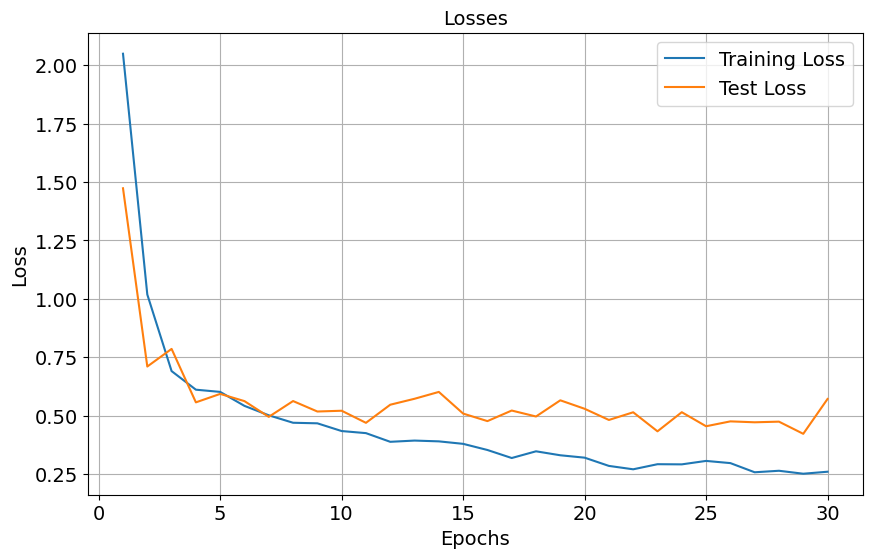

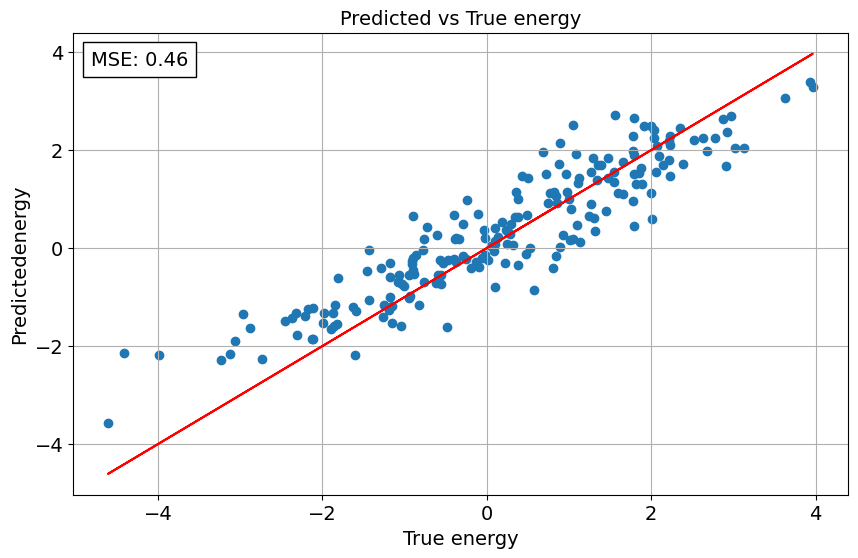

--------------------------------------------


n_dimensions: 4, periodic: True, number of connections: 40


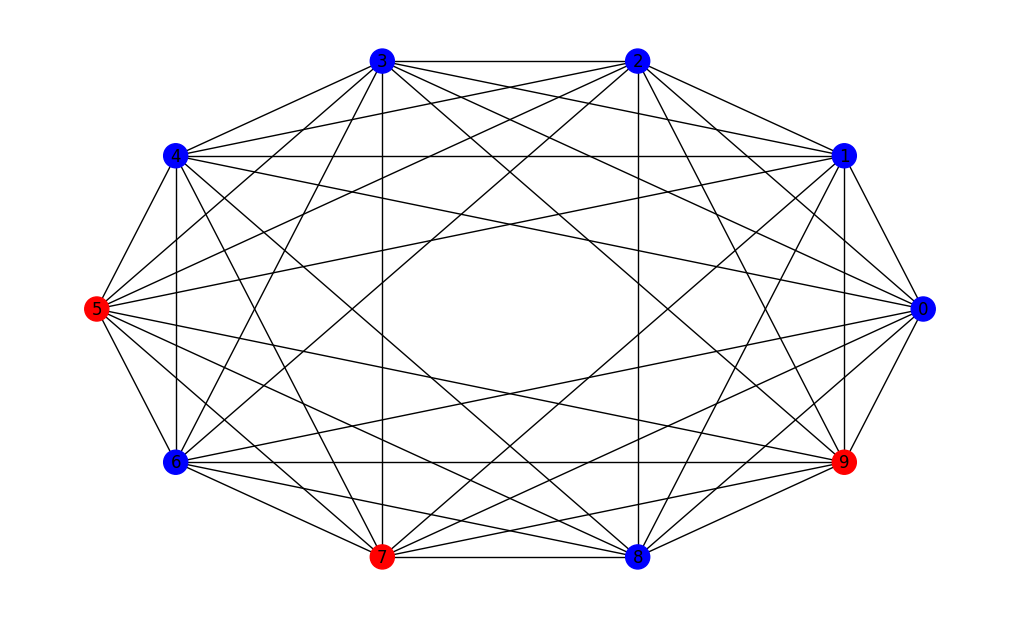

Training ...
Ep 1 	| Loss 3.11537 	| Test Loss 3.21083
Ep 2 	| Loss 2.2666 	| Test Loss 1.86273
Ep 3 	| Loss 1.28672 	| Test Loss 1.05776
Ep 4 	| Loss 0.99504 	| Test Loss 0.80966
Ep 5 	| Loss 0.84036 	| Test Loss 0.77337
Ep 6 	| Loss 0.66756 	| Test Loss 0.75466
Ep 7 	| Loss 0.66802 	| Test Loss 0.69152
Ep 8 	| Loss 0.68132 	| Test Loss 0.84933
Ep 9 	| Loss 0.65228 	| Test Loss 0.71821
Ep 10 	| Loss 0.60198 	| Test Loss 0.74434
Ep 11 	| Loss 0.58907 	| Test Loss 0.64062
Ep 12 	| Loss 0.60506 	| Test Loss 0.58137
Ep 13 	| Loss 0.55802 	| Test Loss 0.73971
Ep 14 	| Loss 0.5117 	| Test Loss 0.54134
Ep 15 	| Loss 0.47727 	| Test Loss 0.61718
Ep 16 	| Loss 0.4892 	| Test Loss 0.58493
Ep 17 	| Loss 0.47165 	| Test Loss 0.62214
Ep 18 	| Loss 0.46016 	| Test Loss 0.66801
Ep 19 	| Loss 0.47926 	| Test Loss 0.66834
Ep 20 	| Loss 0.44561 	| Test Loss 0.58733
Ep 21 	| Loss 0.44214 	| Test Loss 0.63309
Ep 22 	| Loss 0.42921 	| Test Loss 0.6063
Ep 23 	| Loss 0.41939 	| Test Loss 0.58276
Ep 24 	| Lo

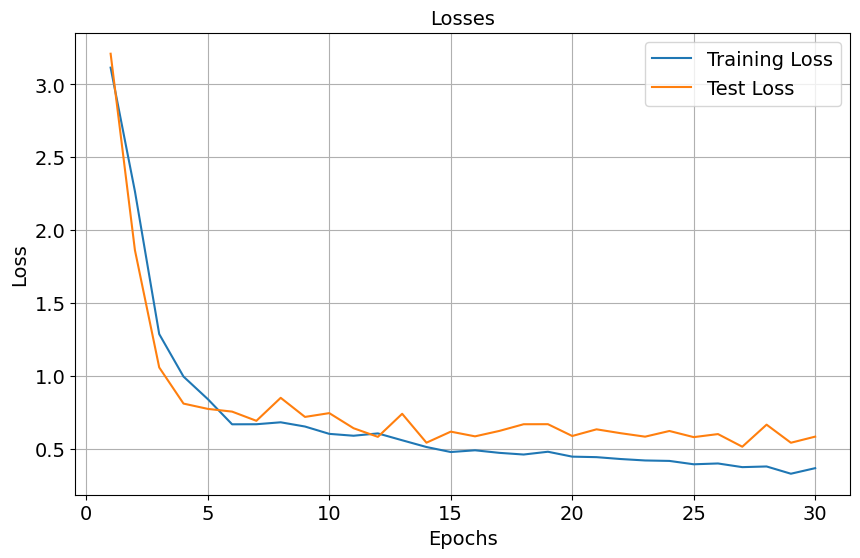

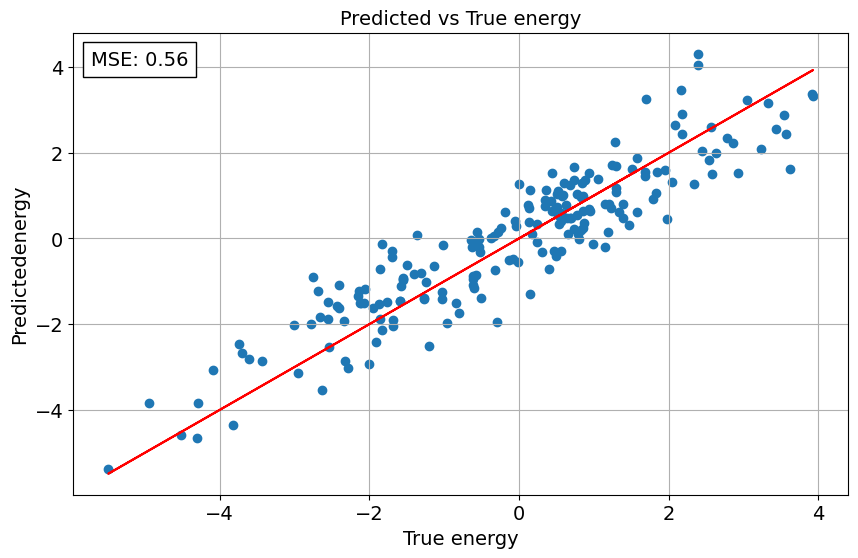

--------------------------------------------


n_dimensions: 5, periodic: False, number of connections: 35


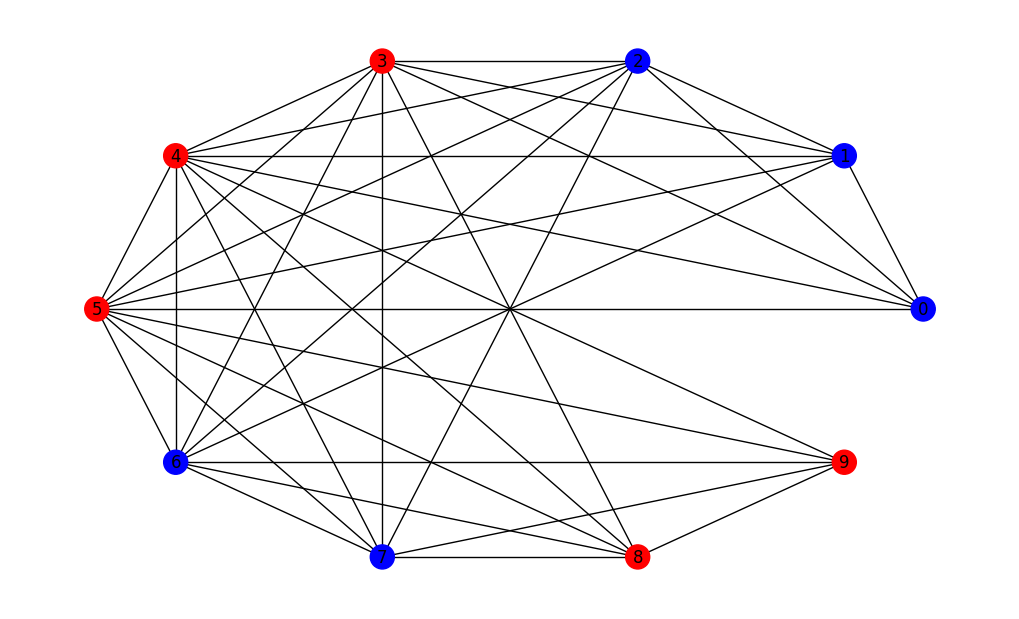

Training ...
Ep 1 	| Loss 2.76835 	| Test Loss 2.8523
Ep 2 	| Loss 1.90621 	| Test Loss 1.2499
Ep 3 	| Loss 0.90136 	| Test Loss 0.91011
Ep 4 	| Loss 0.8615 	| Test Loss 0.87521
Ep 5 	| Loss 0.67484 	| Test Loss 0.77112
Ep 6 	| Loss 0.65718 	| Test Loss 0.7278
Ep 7 	| Loss 0.62843 	| Test Loss 0.65901
Ep 8 	| Loss 0.59948 	| Test Loss 0.5775
Ep 9 	| Loss 0.58363 	| Test Loss 0.57003
Ep 10 	| Loss 0.55099 	| Test Loss 0.73746
Ep 11 	| Loss 0.49493 	| Test Loss 0.65484
Ep 12 	| Loss 0.5105 	| Test Loss 0.71498
Ep 13 	| Loss 0.50112 	| Test Loss 0.70797
Ep 14 	| Loss 0.44968 	| Test Loss 0.59411
Ep 15 	| Loss 0.41705 	| Test Loss 0.63099
Ep 16 	| Loss 0.43526 	| Test Loss 0.63547
Ep 17 	| Loss 0.43231 	| Test Loss 0.6814
Ep 18 	| Loss 0.4184 	| Test Loss 0.63668
Ep 19 	| Loss 0.4022 	| Test Loss 0.51195
Ep 20 	| Loss 0.36408 	| Test Loss 0.62097
Ep 21 	| Loss 0.36408 	| Test Loss 0.67626
Ep 22 	| Loss 0.36078 	| Test Loss 0.56293
Ep 23 	| Loss 0.35445 	| Test Loss 0.47998
Ep 24 	| Loss 0.

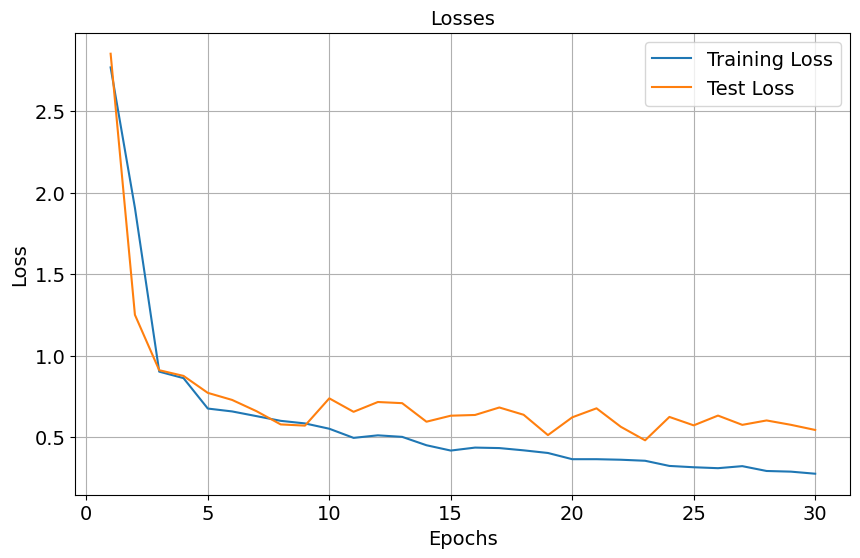

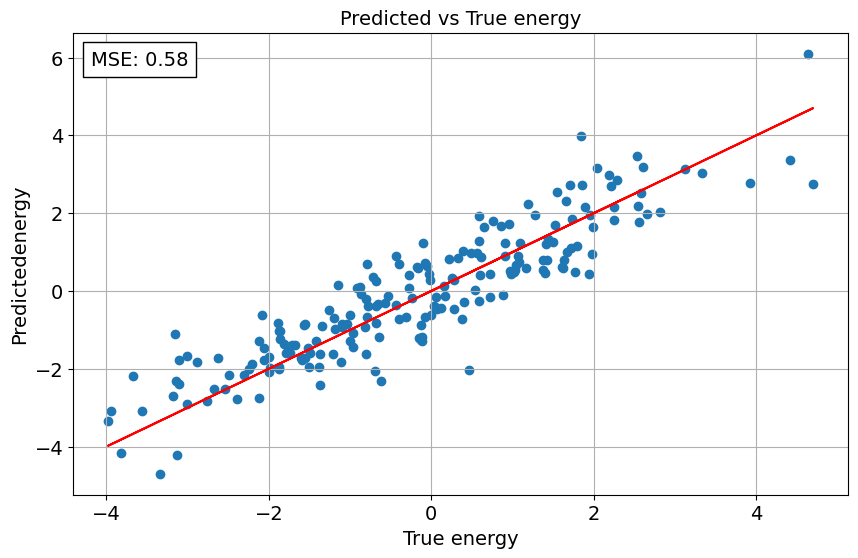

--------------------------------------------


n_dimensions: 5, periodic: True, number of connections: 45


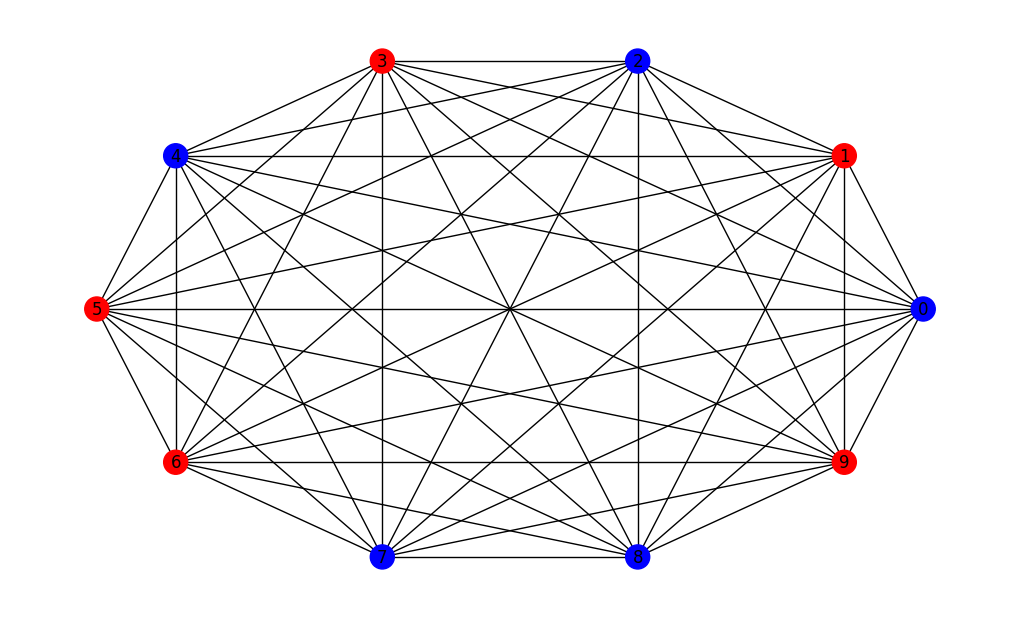

Training ...
Ep 1 	| Loss 3.67007 	| Test Loss 3.65399
Ep 2 	| Loss 2.53417 	| Test Loss 2.13548
Ep 3 	| Loss 1.4596 	| Test Loss 1.24637
Ep 4 	| Loss 0.95354 	| Test Loss 1.23749
Ep 5 	| Loss 0.96686 	| Test Loss 0.90311
Ep 6 	| Loss 0.78168 	| Test Loss 0.90631
Ep 7 	| Loss 0.76577 	| Test Loss 0.87409
Ep 8 	| Loss 0.72522 	| Test Loss 0.85375
Ep 9 	| Loss 0.73232 	| Test Loss 0.84041
Ep 10 	| Loss 0.58415 	| Test Loss 0.9454
Ep 11 	| Loss 0.65513 	| Test Loss 0.8606
Ep 12 	| Loss 0.67936 	| Test Loss 0.91062
Ep 13 	| Loss 0.57551 	| Test Loss 0.68344
Ep 14 	| Loss 0.5996 	| Test Loss 0.93971
Ep 15 	| Loss 0.58635 	| Test Loss 0.71205
Ep 16 	| Loss 0.52736 	| Test Loss 0.7795
Ep 17 	| Loss 0.53234 	| Test Loss 0.87172
Ep 18 	| Loss 0.55973 	| Test Loss 0.66392
Ep 19 	| Loss 0.50549 	| Test Loss 0.93537
Ep 20 	| Loss 0.4676 	| Test Loss 0.84125
Ep 21 	| Loss 0.52966 	| Test Loss 0.6865
Ep 22 	| Loss 0.44651 	| Test Loss 0.8048
Ep 23 	| Loss 0.43024 	| Test Loss 0.73638
Ep 24 	| Loss 0

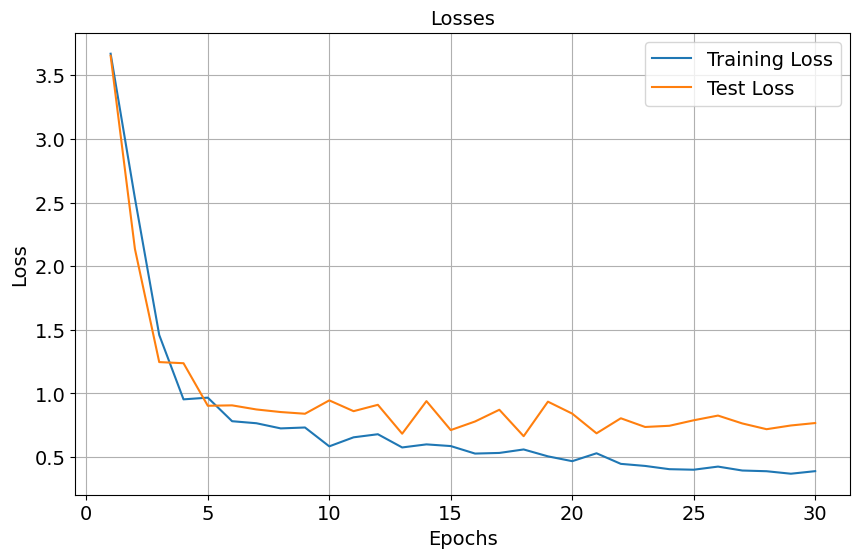

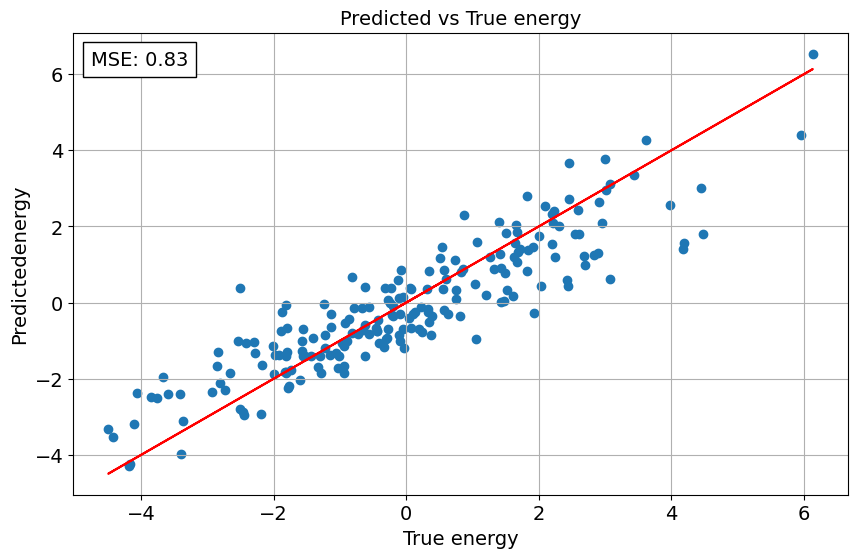

--------------------------------------------




In [23]:
i = 0 # index to keep track of the dataset

for n_dimensions in list_dimensions:
    for periodic in list_periodic:

        dataset = list_datasets[i]
        graphs = list_graphs[i]

        # get number of connections
        n_connections = len(graphs[0].edges)
        list_n_connections.append(n_connections)

        print(f"n_dimensions: {n_dimensions}, periodic: {periodic}, number of connections: {n_connections}")

        # plot the first graph
        fig = plot_graph(graphs[0])


        # split the dataset into training and test set and create the loaders
        train_loader = DataLoader(dataset[:int(0.8*n_samples)], batch_size=batch_size, shuffle=False) # shuffle not needed
        test_loader = DataLoader(dataset[int(0.8*n_samples):], batch_size=batch_size, shuffle=False)

        # copy the model from scratch
        model = GNN(hidden_channels_1=hidden_channels_1, hidden_channels_2=hidden_channels_2, hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4, hidden_linear=hidden_linear, lr=lr, weight_decay=weight_decay, dropout=dropout)

        model.to(device)

        # set the model name
        model_name = set_model_name(n_nodes, n_dimensions, h, periodic, n_samples, hidden_channels_1, hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear, lr, weight_decay, dropout,num_epochs)
        list_model_names.append(model_name)

        try:
            os.mkdir(model_name)
        except:
            pass

        # save the graph plot 
        fig.savefig(model_name + "/graph.png")

        # train the model
        train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience=patience, model_name=model_name, verbose=True, device=device)
        list_train_losses.append(train_losses)
        list_test_losses.append(test_losses)

        # save train and test losses 
        np.save(model_name + '/train_losses.npy', train_losses)
        np.save(model_name + '/test_losses.npy', test_losses)
          

        # plot the losses
        fig_losses = plot_loss(train_losses, test_losses)
        fig_losses.savefig(model_name + "/losses.png")
        list_fig_losses.append(fig_losses)

        # test the trained model
        fig, mse = test_trained_model(model_name, test_loader, device=device)
        fig.savefig(model_name + "/test.png")
        list_fig_tests.append(fig)

        # store the mse
        list_mse.append(mse)

        print(44 * '-')
        print("\n")

        folder_name = f"n_nodes_{n_nodes}_n_dimensions_{n_dimensions}"
        try: os.mkdir(folder_name)
        except: pass

        # move the files to the folder
        os.system(f"mv {model_name} {folder_name}/{model_name}")     

        i += 1 # update the index for the dataset
                     

        

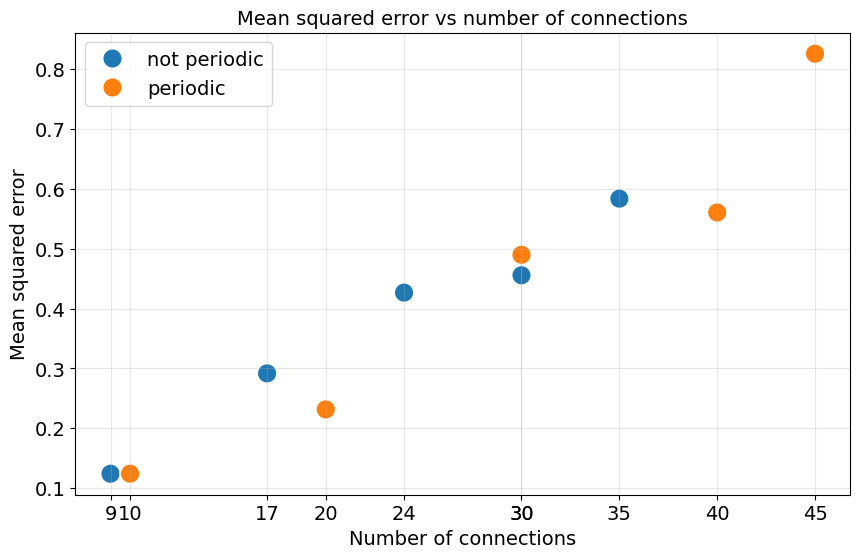

In [24]:
# plot the mse vs the number of connections
fig = plt.figure()
# set a label for even positions on list_n_connections
labels = ["not periodic" if i%2 == 0 else "periodic" for i in np.arange(len(list_n_connections))]


sns.scatterplot(x = list_n_connections, y= list_mse, hue=labels, size=labels, sizes=(200, 200) )

plt.xlabel('Number of connections')
plt.ylabel('Mean squared error')
plt.title('Mean squared error vs number of connections')
plt.xticks(list_n_connections)
plt.grid(alpha=0.3)


plt.show(fig)
fig.savefig(f"mse_vs_connections_{n_samples}_{h}.png")


In [14]:

# move everything to a new folder called n_nodes_10
try: os.mkdir("n_nodes_10")
except: pass

for dim in list_dimensions:
    os.system(f"mv n_nodes_10_n_dimensions_{dim}/* n_nodes_10/n_nodes_10_n_dimensions_{dim}/")
    os.system(f"rm -r n_nodes_10_n_dimensions_{dim}")
#os.system("mv datasets n_nodes_10")

os.system(f"mv mse_vs_connections_{n_samples}_{h}.png n_nodes_10")



0

# Magnetization learning (to be compared with task 2) <a class="anchor" id="magnetization"></a>
The prediction of the magnetization from a GNN is not part of the first task, but here we train a GNN for this purpose in order to compare it with the same task using a MLP in the second task.

In [15]:


# prepare lists to store the results
list_dimensions = [1,2,3,4,5]
list_periodic = [False, True]
list_datasets = []
list_graphs = []
list_n_connections = []
list_model_names = []
list_train_losses = []
list_test_losses = []
list_fig_losses = []
list_fig_tests = []
list_mse = []
create = True
save = True


if create:
    for n_dimensions in list_dimensions:
        for periodic in list_periodic:
            print(f"creating magnetization datasets with: n_dimensions: {n_dimensions}, periodic: {periodic}")
            
            dataset, graphs = create_dataset(n_nodes=n_nodes, h=h, periodic=periodic, n_dimensions=n_dimensions, n_samples=n_samples, save=False, mode="magnetization")
            list_datasets.append(dataset)
            list_graphs.append(graphs)

            if save:
                torch.save(dataset, f"datasets/dataset_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
                torch.save(graphs, f"datasets/graphs_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
else:
    print("loading datasets")
    for n_dimensions in list_dimensions:
        for periodic in list_periodic:
            dataset = torch.load(f"datasets/dataset_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
            graphs = torch.load(f"datasets/graphs_magnetization_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
            list_datasets.append(dataset)
            list_graphs.append(graphs)
print("Done!")



creating magnetization datasets with: n_dimensions: 1, periodic: False
creating magnetization datasets with: n_dimensions: 1, periodic: True
creating magnetization datasets with: n_dimensions: 2, periodic: False
creating magnetization datasets with: n_dimensions: 2, periodic: True
creating magnetization datasets with: n_dimensions: 3, periodic: False
creating magnetization datasets with: n_dimensions: 3, periodic: True
creating magnetization datasets with: n_dimensions: 4, periodic: False
creating magnetization datasets with: n_dimensions: 4, periodic: True
creating magnetization datasets with: n_dimensions: 5, periodic: False
creating magnetization datasets with: n_dimensions: 5, periodic: True
Done!


n_dimensions: 1, periodic: False, number of connections: 9
Training ...


/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Ep 1 	| Loss 8.31972 	| Test Loss 4.60942
Ep 2 	| Loss 4.21845 	| Test Loss 3.55209
Ep 3 	| Loss 3.31698 	| Test Loss 3.66705
Ep 4 	| Loss 3.12333 	| Test Loss 3.41339
Ep 5 	| Loss 2.8187 	| Test Loss 3.09881
Ep 6 	| Loss 2.58998 	| Test Loss 2.53222
Ep 7 	| Loss 2.32184 	| Test Loss 3.03529
Ep 8 	| Loss 2.15065 	| Test Loss 2.31934
Ep 9 	| Loss 2.31097 	| Test Loss 2.78907
Ep 10 	| Loss 2.13708 	| Test Loss 2.61161
Ep 11 	| Loss 2.03874 	| Test Loss 2.5018
Ep 12 	| Loss 2.00937 	| Test Loss 2.26915
Ep 13 	| Loss 1.91085 	| Test Loss 2.66034
Ep 14 	| Loss 1.93807 	| Test Loss 2.3222
Ep 15 	| Loss 1.93329 	| Test Loss 2.47944
Ep 16 	| Loss 1.77839 	| Test Loss 2.25292
Ep 17 	| Loss 1.73758 	| Test Loss 2.48046
Ep 18 	| Loss 1.69991 	| Test Loss 2.21066
Ep 19 	| Loss 1.65194 	| Test Loss 2.31352
Ep 20 	| Loss 1.5674 	| Test Loss 2.32959
Ep 21 	| Loss 1.64364 	| Test Loss 2.36313
Ep 22 	| Loss 1.50177 	| Test Loss 2.43649
Ep 23 	| Loss 1.52543 	| Test Loss 1.94701
Ep 24 	| Loss 1.5032 	| 

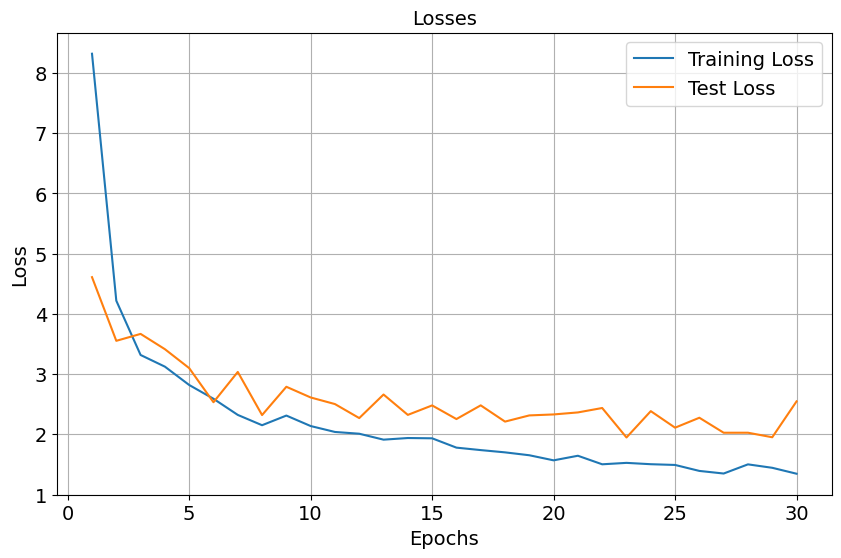

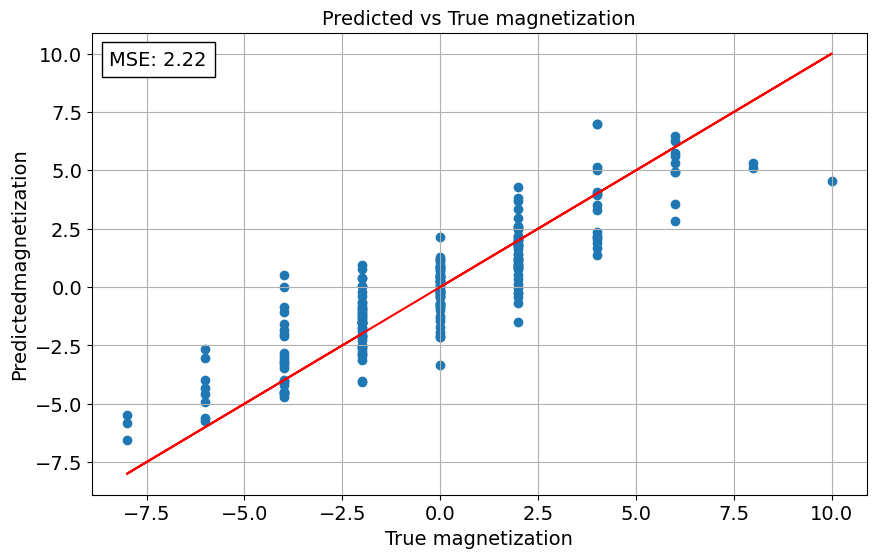

--------------------------------------------


n_dimensions: 1, periodic: True, number of connections: 10
Training ...
Ep 1 	| Loss 8.32177 	| Test Loss 4.33993
Ep 2 	| Loss 4.29902 	| Test Loss 3.44383
Ep 3 	| Loss 3.70304 	| Test Loss 3.20056
Ep 4 	| Loss 3.5205 	| Test Loss 3.29632
Ep 5 	| Loss 3.08626 	| Test Loss 2.81813
Ep 6 	| Loss 2.72955 	| Test Loss 2.66118
Ep 7 	| Loss 2.78253 	| Test Loss 2.53521
Ep 8 	| Loss 2.76131 	| Test Loss 2.88658
Ep 9 	| Loss 2.43355 	| Test Loss 2.7159
Ep 10 	| Loss 2.25551 	| Test Loss 2.46456
Ep 11 	| Loss 2.14939 	| Test Loss 2.60109
Ep 12 	| Loss 2.16743 	| Test Loss 2.22218
Ep 13 	| Loss 2.1591 	| Test Loss 2.05466
Ep 14 	| Loss 2.00505 	| Test Loss 2.45047
Ep 15 	| Loss 2.02635 	| Test Loss 1.95025
Ep 16 	| Loss 1.99992 	| Test Loss 2.01522
Ep 17 	| Loss 1.88256 	| Test Loss 1.97138
Ep 18 	| Loss 1.7472 	| Test Loss 2.14164
Ep 19 	| Loss 1.83069 	| Test Loss 2.21977
Ep 20 	| Loss 1.86627 	| Test Loss 1.86574
Ep 21 	| Loss 1.72187 	| Test Loss

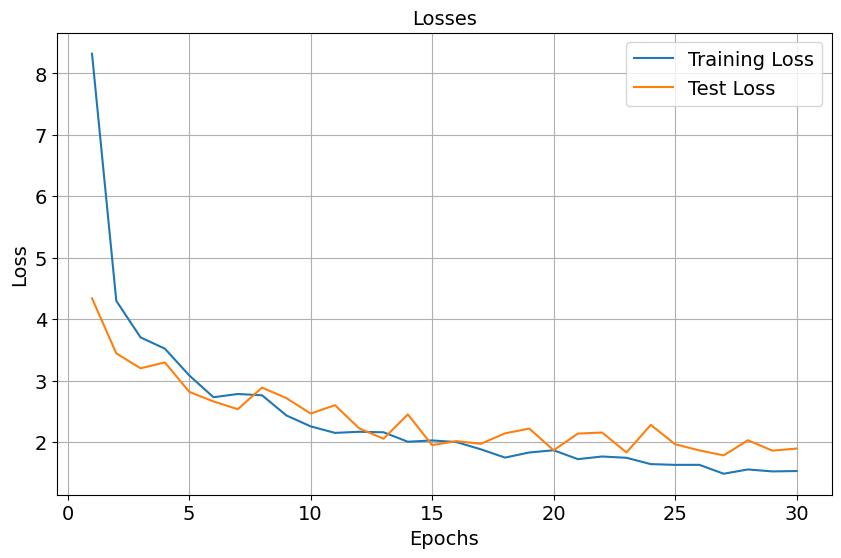

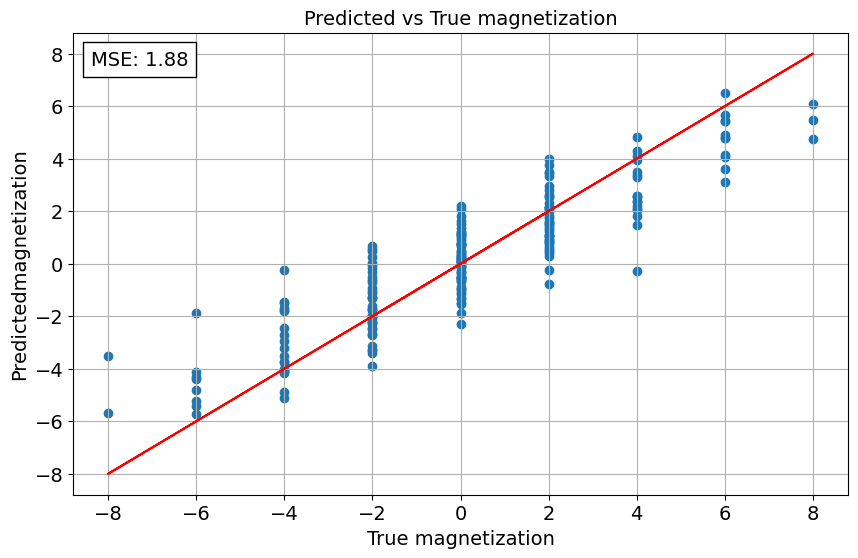

--------------------------------------------


n_dimensions: 2, periodic: False, number of connections: 17
Training ...
Ep 1 	| Loss 8.16826 	| Test Loss 5.25161
Ep 2 	| Loss 4.47025 	| Test Loss 4.10319
Ep 3 	| Loss 3.6961 	| Test Loss 4.07334
Ep 4 	| Loss 3.47428 	| Test Loss 3.71691
Ep 5 	| Loss 3.23158 	| Test Loss 3.82176
Ep 6 	| Loss 2.95724 	| Test Loss 3.57713
Ep 7 	| Loss 2.91333 	| Test Loss 3.69483
Ep 8 	| Loss 2.75632 	| Test Loss 3.38699
Ep 9 	| Loss 2.66448 	| Test Loss 3.32606
Ep 10 	| Loss 2.33916 	| Test Loss 3.0461
Ep 11 	| Loss 2.42171 	| Test Loss 2.90761
Ep 12 	| Loss 2.24742 	| Test Loss 2.91642
Ep 13 	| Loss 2.24129 	| Test Loss 2.93135
Ep 14 	| Loss 2.35975 	| Test Loss 3.17794
Ep 15 	| Loss 2.05765 	| Test Loss 2.65411
Ep 16 	| Loss 2.18778 	| Test Loss 2.54721
Ep 17 	| Loss 2.02834 	| Test Loss 2.77128
Ep 18 	| Loss 2.04104 	| Test Loss 3.34595
Ep 19 	| Loss 2.01761 	| Test Loss 2.17317
Ep 20 	| Loss 1.91436 	| Test Loss 2.82601
Ep 21 	| Loss 1.91216 	| Test L

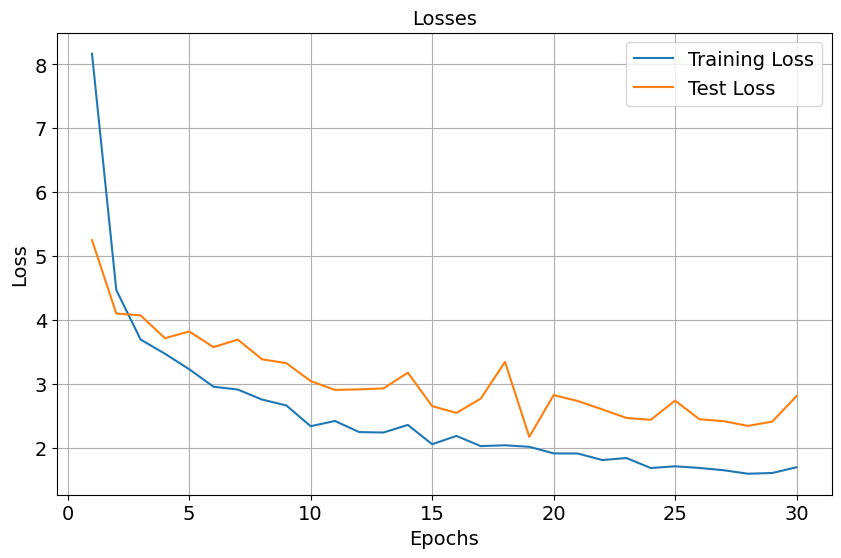

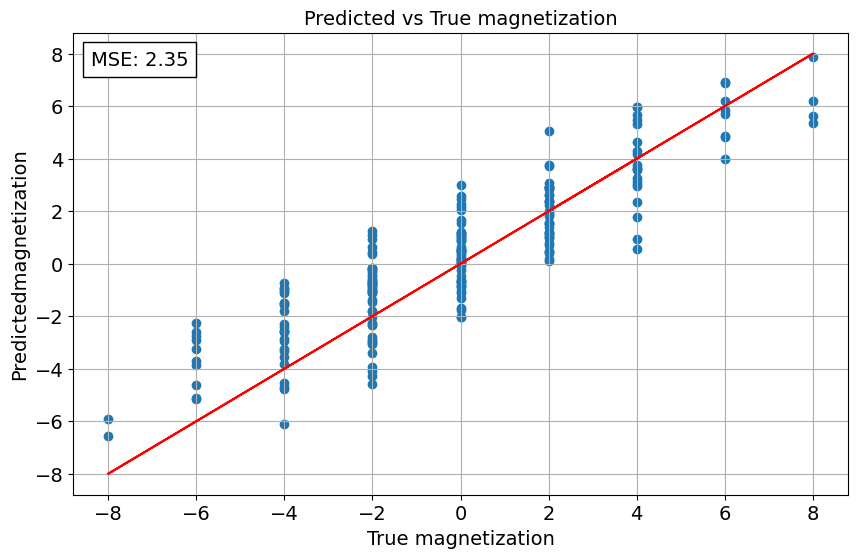

--------------------------------------------


n_dimensions: 2, periodic: True, number of connections: 20
Training ...
Ep 1 	| Loss 8.01472 	| Test Loss 5.28409
Ep 2 	| Loss 4.96551 	| Test Loss 3.5494
Ep 3 	| Loss 4.19494 	| Test Loss 4.00398
Ep 4 	| Loss 3.49107 	| Test Loss 3.10353
Ep 5 	| Loss 3.35469 	| Test Loss 2.78016
Ep 6 	| Loss 3.13493 	| Test Loss 2.66131
Ep 7 	| Loss 2.83459 	| Test Loss 2.98857
Ep 8 	| Loss 2.56292 	| Test Loss 3.01969
Ep 9 	| Loss 2.64378 	| Test Loss 2.59333
Ep 10 	| Loss 2.41648 	| Test Loss 2.36774
Ep 11 	| Loss 2.18679 	| Test Loss 2.43793
Ep 12 	| Loss 2.29632 	| Test Loss 2.65515
Ep 13 	| Loss 2.02266 	| Test Loss 2.43862
Ep 14 	| Loss 2.11187 	| Test Loss 2.07086
Ep 15 	| Loss 2.06765 	| Test Loss 2.44387
Ep 16 	| Loss 2.16284 	| Test Loss 2.18171
Ep 17 	| Loss 1.93606 	| Test Loss 2.2916
Ep 18 	| Loss 1.8479 	| Test Loss 2.30095
Ep 19 	| Loss 1.9173 	| Test Loss 2.0826
Ep 20 	| Loss 1.81773 	| Test Loss 1.95373
Ep 21 	| Loss 1.75541 	| Test Loss 

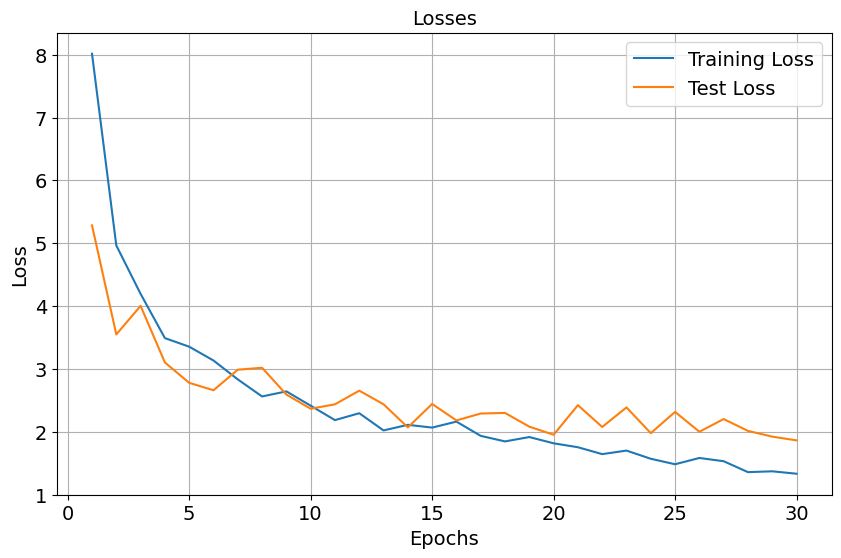

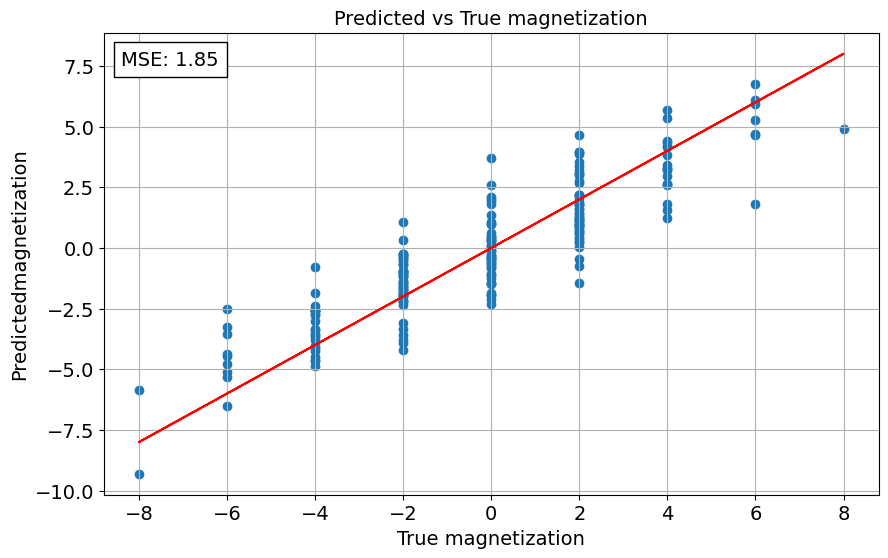

--------------------------------------------


n_dimensions: 3, periodic: False, number of connections: 24
Training ...
Ep 1 	| Loss 8.66996 	| Test Loss 7.25593
Ep 2 	| Loss 5.07982 	| Test Loss 4.68449
Ep 3 	| Loss 4.086 	| Test Loss 4.15568
Ep 4 	| Loss 3.71477 	| Test Loss 4.29052
Ep 5 	| Loss 3.21121 	| Test Loss 3.67422
Ep 6 	| Loss 3.14164 	| Test Loss 3.5997
Ep 7 	| Loss 2.77852 	| Test Loss 3.56297
Ep 8 	| Loss 2.60335 	| Test Loss 3.71295
Ep 9 	| Loss 2.76556 	| Test Loss 3.66537
Ep 10 	| Loss 2.50337 	| Test Loss 3.563
Ep 11 	| Loss 2.51042 	| Test Loss 3.36163
Ep 12 	| Loss 2.22462 	| Test Loss 3.23347
Ep 13 	| Loss 2.20308 	| Test Loss 2.69845
Ep 14 	| Loss 2.13161 	| Test Loss 2.96517
Ep 15 	| Loss 1.96941 	| Test Loss 3.49725
Ep 16 	| Loss 1.85757 	| Test Loss 3.37006
Ep 17 	| Loss 1.7467 	| Test Loss 2.84912
Ep 18 	| Loss 1.7634 	| Test Loss 3.01842
Ep 19 	| Loss 1.82615 	| Test Loss 2.96337
Ep 20 	| Loss 1.80371 	| Test Loss 2.69105
Ep 21 	| Loss 1.72815 	| Test Loss 3

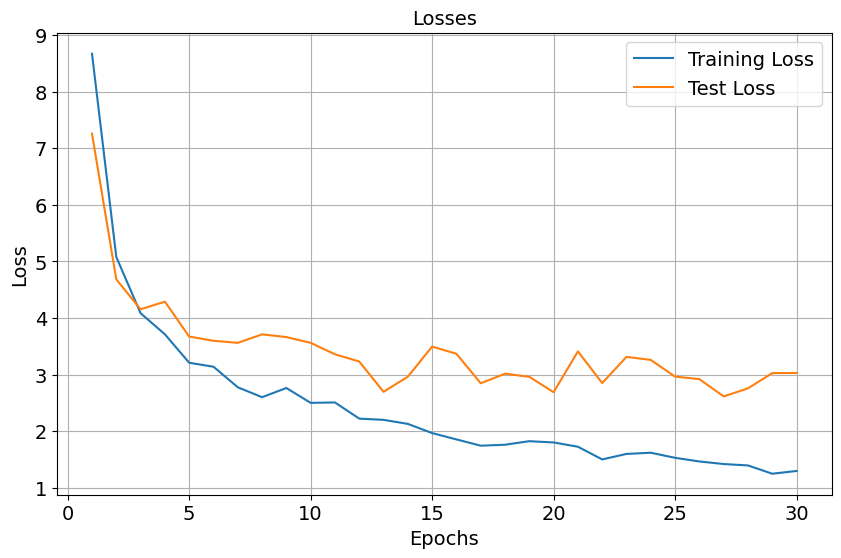

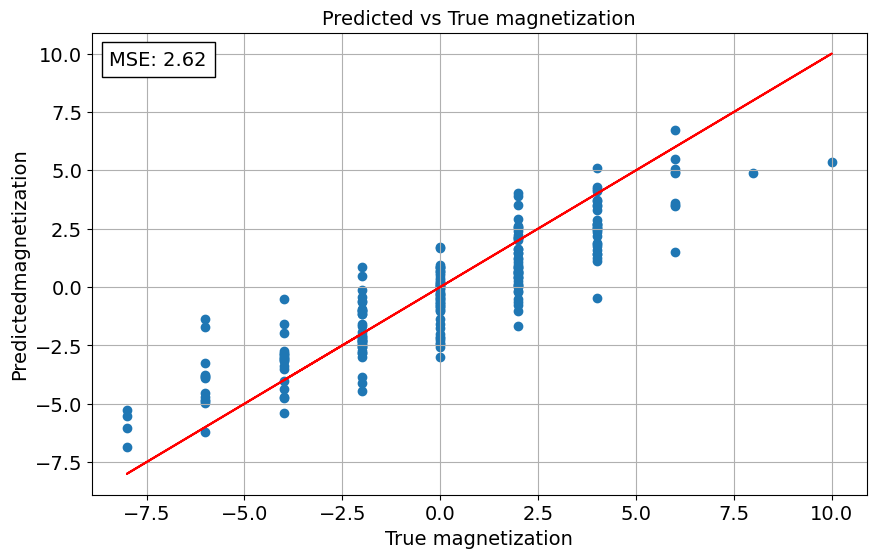

--------------------------------------------


n_dimensions: 3, periodic: True, number of connections: 30
Training ...
Ep 1 	| Loss 8.34566 	| Test Loss 5.27461
Ep 2 	| Loss 4.76353 	| Test Loss 5.44408
Ep 3 	| Loss 4.05532 	| Test Loss 4.22801
Ep 4 	| Loss 3.6796 	| Test Loss 3.28365
Ep 5 	| Loss 3.35211 	| Test Loss 3.64847
Ep 6 	| Loss 3.10862 	| Test Loss 3.77965
Ep 7 	| Loss 2.93911 	| Test Loss 2.86313
Ep 8 	| Loss 2.76714 	| Test Loss 3.80387
Ep 9 	| Loss 2.55692 	| Test Loss 3.69001
Ep 10 	| Loss 2.57316 	| Test Loss 3.36883
Ep 11 	| Loss 2.17977 	| Test Loss 3.4501
Ep 12 	| Loss 2.26117 	| Test Loss 4.03271
Ep 13 	| Loss 2.234 	| Test Loss 3.68843
Ep 14 	| Loss 2.09274 	| Test Loss 3.39195
Ep 15 	| Loss 2.08779 	| Test Loss 2.61661
Ep 16 	| Loss 2.02539 	| Test Loss 3.24283
Ep 17 	| Loss 1.94161 	| Test Loss 3.72097
Ep 18 	| Loss 1.83431 	| Test Loss 2.7963
Ep 19 	| Loss 1.77336 	| Test Loss 2.87727
Ep 20 	| Loss 1.77917 	| Test Loss 3.60013
Ep 21 	| Loss 1.68639 	| Test Loss 

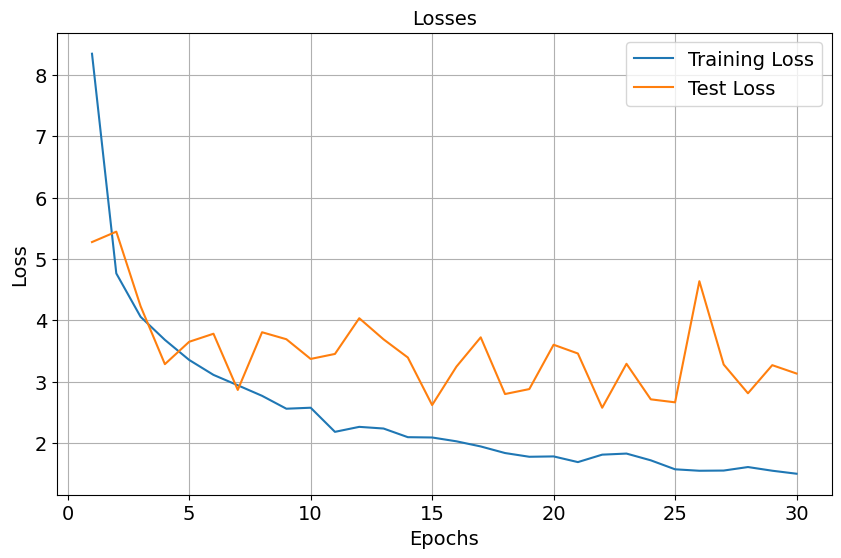

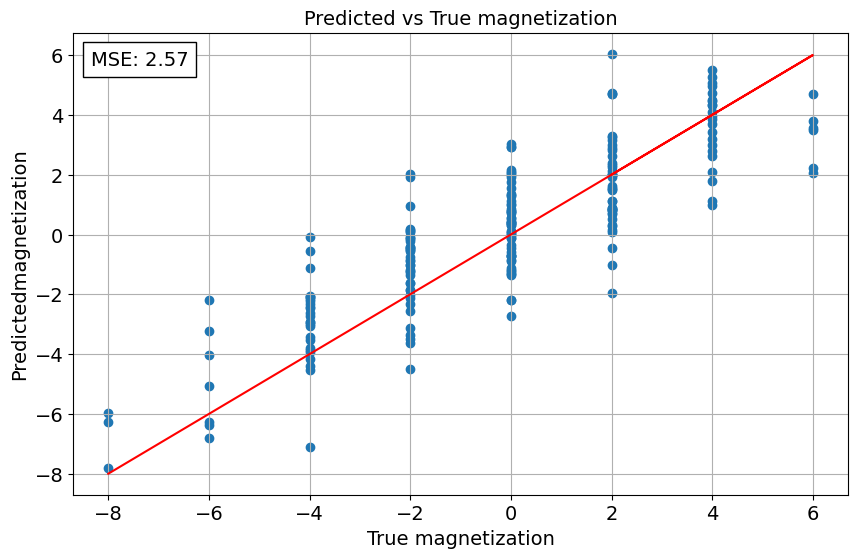

--------------------------------------------


n_dimensions: 4, periodic: False, number of connections: 30
Training ...
Ep 1 	| Loss 7.78517 	| Test Loss 5.56384
Ep 2 	| Loss 4.70806 	| Test Loss 4.52953
Ep 3 	| Loss 3.94028 	| Test Loss 4.50686
Ep 4 	| Loss 3.32697 	| Test Loss 3.80454
Ep 5 	| Loss 3.31954 	| Test Loss 3.52236
Ep 6 	| Loss 3.15971 	| Test Loss 3.49974
Ep 7 	| Loss 2.78286 	| Test Loss 3.69419
Ep 8 	| Loss 2.9529 	| Test Loss 3.46942
Ep 9 	| Loss 2.52133 	| Test Loss 3.66866
Ep 10 	| Loss 2.61747 	| Test Loss 3.47562
Ep 11 	| Loss 2.2595 	| Test Loss 3.23161
Ep 12 	| Loss 2.31219 	| Test Loss 3.63051
Ep 13 	| Loss 2.23346 	| Test Loss 2.9774
Ep 14 	| Loss 2.20446 	| Test Loss 3.19402
Ep 15 	| Loss 1.93913 	| Test Loss 4.14024
Ep 16 	| Loss 2.1893 	| Test Loss 3.43284
Ep 17 	| Loss 1.86512 	| Test Loss 3.4846
Ep 18 	| Loss 1.87346 	| Test Loss 2.95174
Ep 19 	| Loss 1.65957 	| Test Loss 3.43645
Ep 20 	| Loss 1.67956 	| Test Loss 3.23127
Ep 21 	| Loss 1.72817 	| Test Loss

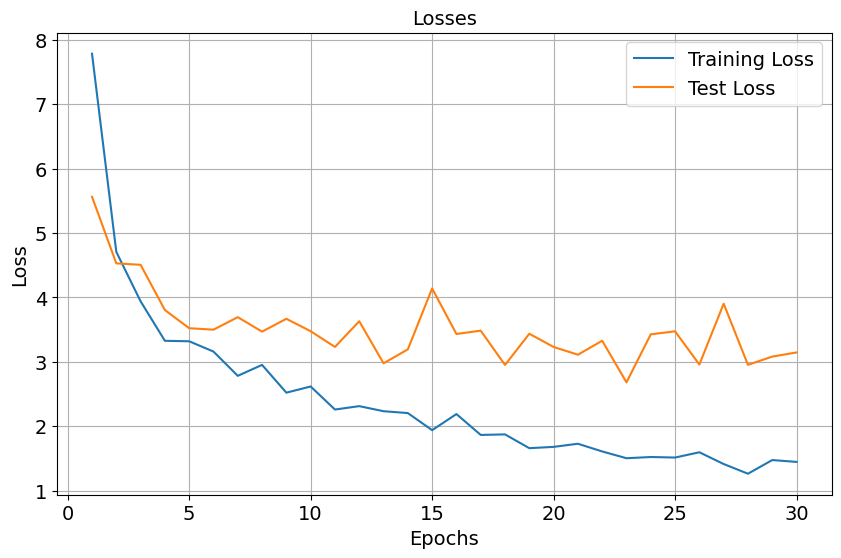

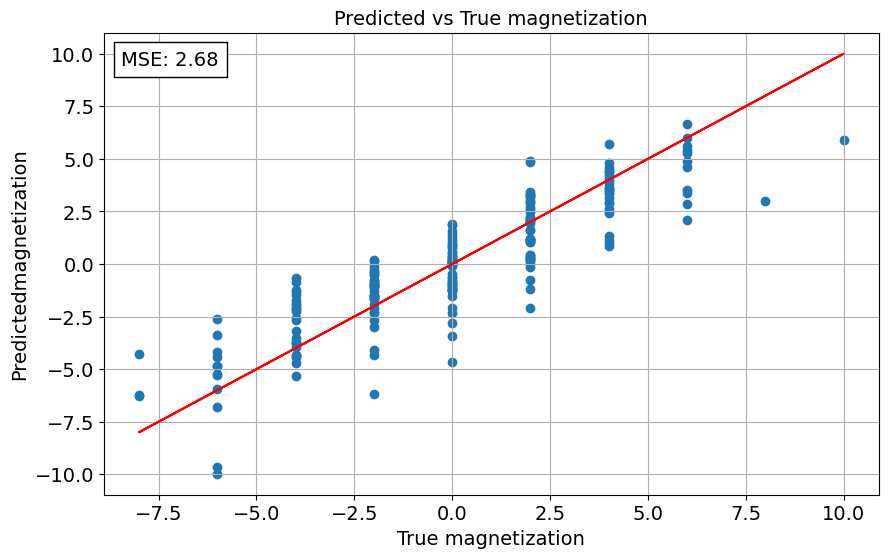

--------------------------------------------


n_dimensions: 4, periodic: True, number of connections: 40
Training ...
Ep 1 	| Loss 7.79105 	| Test Loss 6.36764
Ep 2 	| Loss 5.16003 	| Test Loss 5.05848
Ep 3 	| Loss 4.20134 	| Test Loss 4.70418
Ep 4 	| Loss 3.75565 	| Test Loss 3.64879
Ep 5 	| Loss 3.4224 	| Test Loss 3.81176
Ep 6 	| Loss 3.04678 	| Test Loss 2.85406
Ep 7 	| Loss 2.90383 	| Test Loss 3.26413
Ep 8 	| Loss 2.77218 	| Test Loss 3.12034
Ep 9 	| Loss 2.78814 	| Test Loss 3.14661
Ep 10 	| Loss 2.51401 	| Test Loss 3.27422
Ep 11 	| Loss 2.46232 	| Test Loss 3.16747
Ep 12 	| Loss 2.37417 	| Test Loss 2.77101
Ep 13 	| Loss 2.15128 	| Test Loss 3.16727
Ep 14 	| Loss 2.21408 	| Test Loss 3.05679
Ep 15 	| Loss 2.04802 	| Test Loss 2.84338
Ep 16 	| Loss 2.08516 	| Test Loss 2.925
Ep 17 	| Loss 2.02667 	| Test Loss 2.93654
Ep 18 	| Loss 1.9993 	| Test Loss 2.80873
Ep 19 	| Loss 1.96244 	| Test Loss 2.59776
Ep 20 	| Loss 1.76088 	| Test Loss 3.10298
Ep 21 	| Loss 1.87601 	| Test Loss

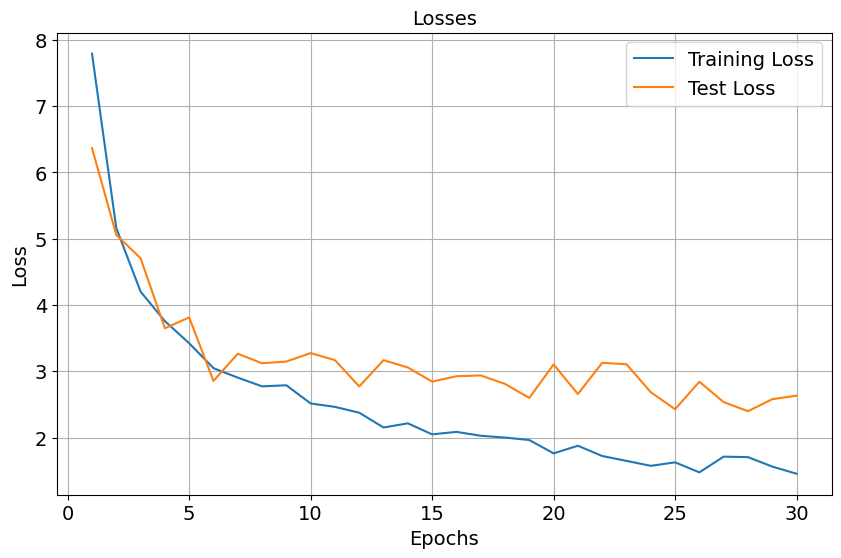

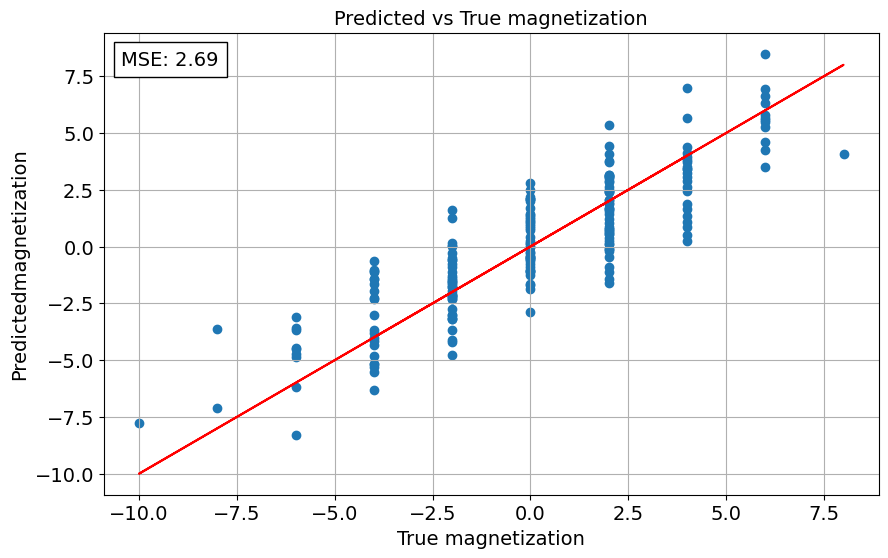

--------------------------------------------


n_dimensions: 5, periodic: False, number of connections: 35
Training ...
Ep 1 	| Loss 8.61355 	| Test Loss 6.88664
Ep 2 	| Loss 5.04524 	| Test Loss 4.91175
Ep 3 	| Loss 4.23887 	| Test Loss 4.72486
Ep 4 	| Loss 3.73641 	| Test Loss 4.2355
Ep 5 	| Loss 3.53311 	| Test Loss 3.97016
Ep 6 	| Loss 3.15161 	| Test Loss 4.05258
Ep 7 	| Loss 2.97123 	| Test Loss 3.6102
Ep 8 	| Loss 2.7939 	| Test Loss 3.7392
Ep 9 	| Loss 2.51484 	| Test Loss 3.73859
Ep 10 	| Loss 2.36099 	| Test Loss 3.11667
Ep 11 	| Loss 2.50103 	| Test Loss 3.62454
Ep 12 	| Loss 2.18491 	| Test Loss 3.14735
Ep 13 	| Loss 2.08631 	| Test Loss 3.10802
Ep 14 	| Loss 1.95279 	| Test Loss 3.0272
Ep 15 	| Loss 1.77045 	| Test Loss 2.6278
Ep 16 	| Loss 1.76973 	| Test Loss 3.33357
Ep 17 	| Loss 1.94943 	| Test Loss 2.98036
Ep 18 	| Loss 1.70508 	| Test Loss 3.285
Ep 19 	| Loss 1.74116 	| Test Loss 3.14792
Ep 20 	| Loss 1.71955 	| Test Loss 3.10205
Ep 21 	| Loss 1.74953 	| Test Loss 2.

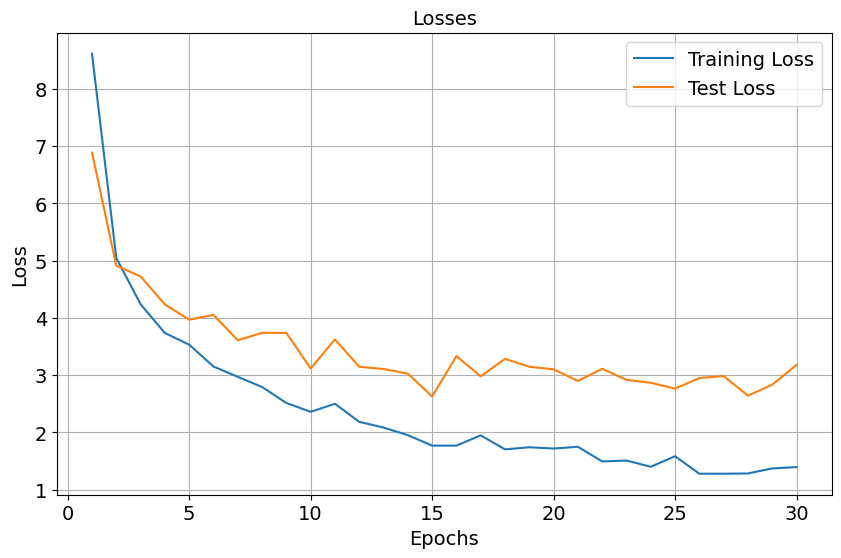

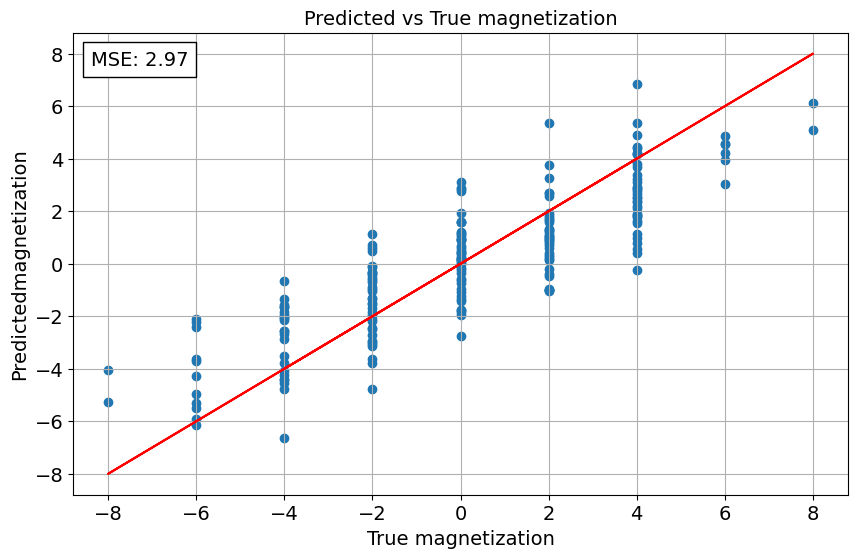

--------------------------------------------


n_dimensions: 5, periodic: True, number of connections: 45
Training ...
Ep 1 	| Loss 8.3975 	| Test Loss 5.85723
Ep 2 	| Loss 5.54167 	| Test Loss 4.08053
Ep 3 	| Loss 4.62274 	| Test Loss 3.86031
Ep 4 	| Loss 3.94698 	| Test Loss 3.48882
Ep 5 	| Loss 3.58526 	| Test Loss 3.59366
Ep 6 	| Loss 3.36599 	| Test Loss 3.1852
Ep 7 	| Loss 3.22001 	| Test Loss 2.70615
Ep 8 	| Loss 2.97321 	| Test Loss 3.08825
Ep 9 	| Loss 2.77109 	| Test Loss 2.62801
Ep 10 	| Loss 2.57029 	| Test Loss 2.73792
Ep 11 	| Loss 2.52269 	| Test Loss 2.92096
Ep 12 	| Loss 2.1709 	| Test Loss 2.85325
Ep 13 	| Loss 2.42326 	| Test Loss 2.81199
Ep 14 	| Loss 2.08636 	| Test Loss 3.40572
Ep 15 	| Loss 2.15432 	| Test Loss 2.67294
Ep 16 	| Loss 2.0557 	| Test Loss 2.52112
Ep 17 	| Loss 2.22072 	| Test Loss 2.70059
Ep 18 	| Loss 1.96234 	| Test Loss 2.70045
Ep 19 	| Loss 1.89572 	| Test Loss 2.67944
Ep 20 	| Loss 1.77587 	| Test Loss 2.65857
Ep 21 	| Loss 1.69822 	| Test Loss

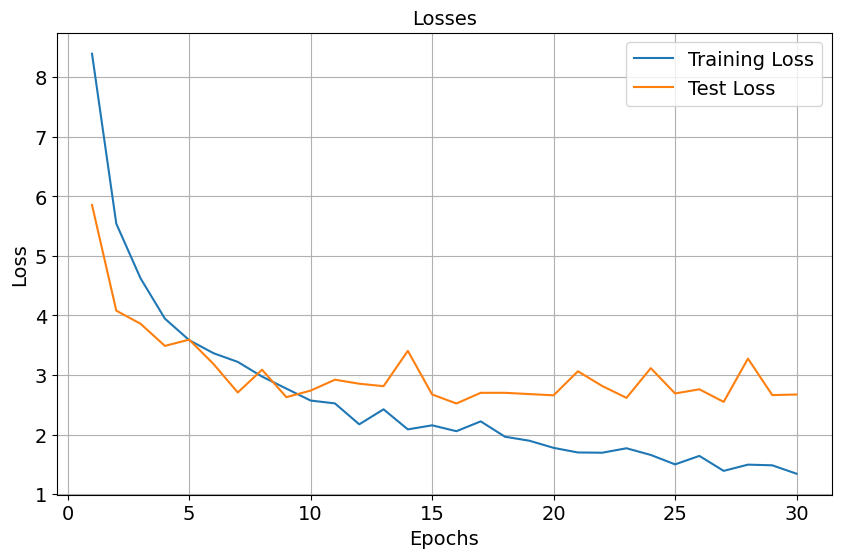

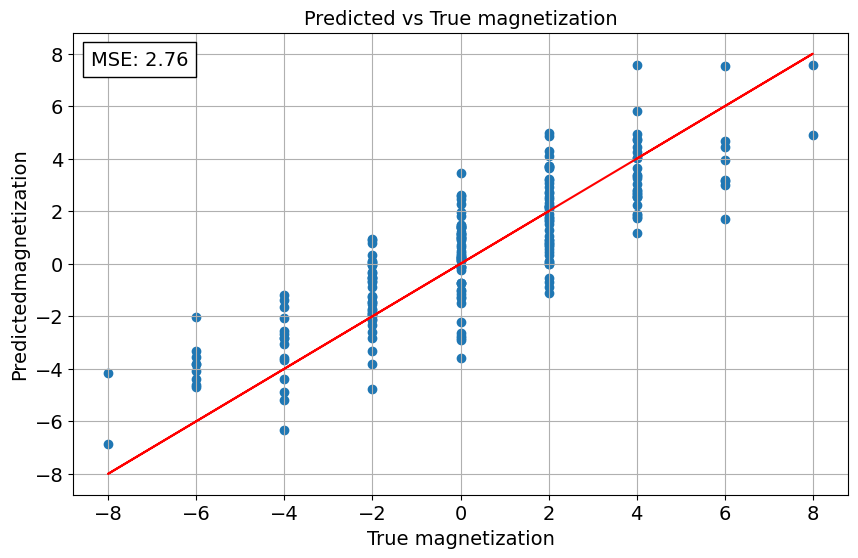

--------------------------------------------




In [16]:
i = 0 # index to keep track of the dataset

for n_dimensions in list_dimensions:
    for periodic in list_periodic:

        dataset = list_datasets[i]
        graphs = list_graphs[i]

        # get number of connections
        n_connections = len(graphs[0].edges)
        list_n_connections.append(n_connections)

        print(f"n_dimensions: {n_dimensions}, periodic: {periodic}, number of connections: {n_connections}")


        # split the dataset into training and test set and create the loaders
        train_loader = DataLoader(dataset[:int(0.8*n_samples)], batch_size=batch_size, shuffle=False) # shuffle not needed
        test_loader = DataLoader(dataset[int(0.8*n_samples):], batch_size=batch_size, shuffle=False)

        # copy the model from scratch
        model = GNN(hidden_channels_1=hidden_channels_1, hidden_channels_2=hidden_channels_2, hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4, hidden_linear=hidden_linear, lr=lr, weight_decay=weight_decay, dropout=dropout)

        model.to(device)

        # set the model name
        model_name = set_model_name(n_nodes, n_dimensions, h, periodic, n_samples, hidden_channels_1, hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear, lr, weight_decay, dropout,num_epochs) + "_magnetization"
        list_model_names.append(model_name)

        try:
            os.mkdir(model_name )
        except:
            pass

        # save the graph plot 
        fig.savefig(model_name + "/graph.png")

        # train the model
        train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience=patience, model_name=model_name, verbose=True, device=device)
        list_train_losses.append(train_losses)
        list_test_losses.append(test_losses)

        # save train and test losses 
        np.save(model_name + '/train_losses.npy', train_losses)
        np.save(model_name + '/test_losses.npy', test_losses)
          

        # plot the losses
        fig_losses = plot_loss(train_losses, test_losses)
        fig_losses.savefig(model_name + "/losses.png")
        list_fig_losses.append(fig_losses)

        # test the trained model
        fig, mse = test_trained_model(model_name, test_loader, device=device,ax_name="magnetization")
        fig.savefig(model_name + "/test.png")
        list_fig_tests.append(fig)

        # store the mse
        list_mse.append(mse)

        print(44 * '-')
        print("\n")

        folder_name = f"n_nodes_{n_nodes}_n_dimensions_{n_dimensions}"
        try: os.mkdir(folder_name)
        except: pass

        # move the files to the folder
        os.system(f"mv {model_name} {folder_name}/{model_name}")     

        i += 1 # update the index for the dataset
                     

        

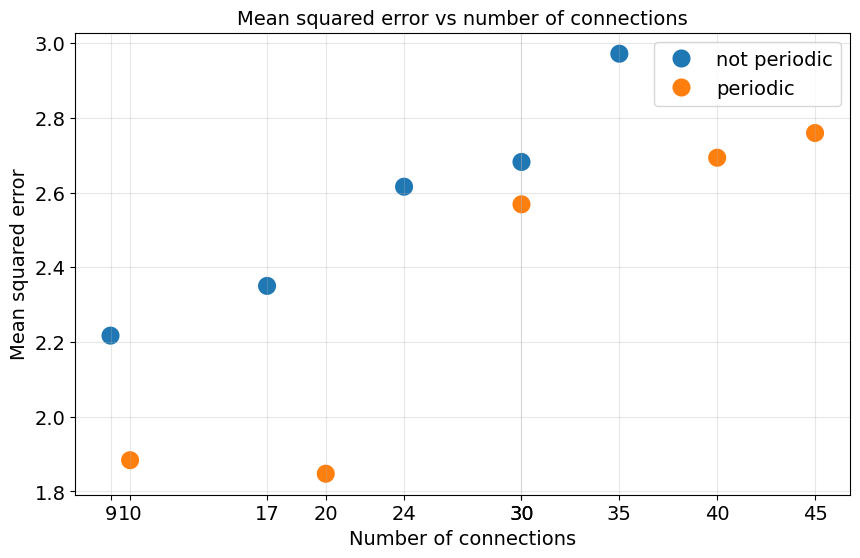

In [18]:
# plot the mse vs the number of connections
fig = plt.figure()
# set a label for even positions on list_n_connections
labels = ["not periodic" if i%2 == 0 else "periodic" for i in np.arange(len(list_n_connections))]


sns.scatterplot(x = list_n_connections, y= list_mse, hue=labels, size=labels, sizes=(200, 200) )

plt.xlabel('Number of connections')
plt.ylabel('Mean squared error')
plt.title('Mean squared error vs number of connections')
plt.xticks(list_n_connections)
plt.grid(alpha=0.3)


plt.show(fig)
fig.savefig(f"mse_vs_connections_{n_samples}_magnetization.png")
